# [Problem Statement](https://www.hackerearth.com/challenges/competitive/hackerearth-machine-learning-challenge-predict-windmill-power/problems/)

> Aim: To predict the Power generated by WindMill.

> Contest Score: **97.21**.

> Public leaderboard Rank: **9**, Private leaderboard Rank: **13**.

> Language Used: **R**

> ![](http://images.all-free-download.com/images/graphiclarge/ecological_and_wind_power_02_hd_pictures_168735.jpg)

# Importing Data & libraries 

In [1]:
# Importing Required Libraries

library(readr)          # Data Read & Manipulation
library(dplyr)          # Data Manipulation
library(superml)        # Label Encoding
library(imputeTS)       # Mean Imputing

library(outliers)       # Remove Outliers
library(funModeling)    # Analysing Numeric Features
library(naniar)         # Analysis Missing Values
library(ggplot2)        # Correlation Matrix 
library(GGally)         # Correlation Matrix 

library(MASS)           # Forward Backward Selection
library(h2o)            # AutoML

library(htmltools)      # HTML/JS Embed in R Markdown
options(warn=-1)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: R6

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


funModeling v.1.9.3 :)
Examples and tutorials at livebook.datascienceheroes.com
 / Now in Spanish: librovivodecienciadedatos.ai

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘GGally’


The following object is masked from ‘package:funModeling’:

    rang

In [2]:
# Importing the Train Data

train = read_csv("../input/predict-the-powerkwh-produced-by-windmills/dataset/train.csv")
head(train,2)


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  tracking_id = col_character(),
  datetime = col_datetime(format = ""),
  turbine_status = col_character(),
  cloud_level = col_character()
)
ℹ Use `spec()` for the full column specifications.




tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),⋯,windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
WM_33725,2019-08-04 14:33:20,94.82002,-99.00000,41.72302,-0.9034229,82.41057,42.52302,2563.125,76.66556,⋯,NA,239.8364,2730.311,42.08467,BA,Medium,2.217542,0.3140648,24.28169,6.766521
WM_698,2018-11-05 10:13:20,241.83273,27.76478,-99.00000,-99.0000000,44.10492,46.25887,2372.384,78.12980,⋯,NA,337.9447,1780.207,107.88864,A2,Medium,4.210346,0.4484944,27.26214,5.966275


In [3]:
# Importing the Test Data

test = read_csv("../input/predict-the-powerkwh-produced-by-windmills/dataset/test.csv")
head(test,2)


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  tracking_id = col_character(),
  datetime = col_datetime(format = ""),
  turbine_status = col_character(),
  cloud_level = col_character()
)
ℹ Use `spec()` for the full column specifications.




tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),⋯,area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
WM_19817,2019-04-17 08:53:20,94.32427,17.64119,89.71419,51.14679,40.46056,39.59473,1073.2027,66.83004,⋯,24.00481,43.75669,445.9770,1664.222,21.91224,BA,Medium,3.185837,0.4039655,25.57243
WM_18723,2019-03-30 07:43:20,10.08887,13.97812,43.27285,46.51639,40.02779,41.17686,517.4364,37.28416,⋯,29.43181,42.72817,499.5953,1165.112,-35.05009,A,Medium,3.016603,0.4447555,24.37182


# Data Preparation

In [4]:
# Changing Column Names 
    
rename = function(df, name){
    for(i in 1:ncol(df))
        colnames(df)[i] = name[i]
    return(df)
}
    
names = c("tracking_id","datetime","wind_speed","atmospheric_temperature","shaft_temperature","blades_angle","gearbox_temperature",
            "engine_temperature","motor_torque","generator_temperature","atmospheric_pressure","area_temperature",
            "windmill_body_temperature","wind_direction","resistance","rotor_torque","turbine_status","cloud_level",
            "blade_length","blade_breadth","windmill_height","windmill_generated_power")

train = rename(train, names)
test = rename(test, names[1:(length(names) - 1)])

In [5]:
# Splitting Date Time Feature to Date

splitting_date_time = function(df)
{    
  df$Date = as.Date(df$datetime)
  datetxt = as.Date(df$Date)
  df_date = data.frame(year = as.numeric(format(datetxt, format = "%Y")),
                       month = as.numeric(format(datetxt, format = "%m")),
                       day = as.numeric(format(datetxt, format = "%d")))
  df = cbind(df_date, df)
  return(df)
}

train = splitting_date_time(train)
test = splitting_date_time(test)

In [6]:
# Dropping records having Windmill Power = NA & Unwanted Features

train = train[!(is.na(train$windmill_generated_power)),]

train = dplyr::select(train, -tracking_id, -datetime, -Date)
test = dplyr::select(test, -tracking_id, -datetime, -Date)

# Exploratory Data Analysis on Train & Test Data

### 1. Data Summary

In [7]:
summary(train)

      year          month            day          wind_speed     
 Min.   :2018   Min.   : 1.00   Min.   : 1.00   Min.   :-496.21  
 1st Qu.:2019   1st Qu.: 3.00   1st Qu.: 8.00   1st Qu.:  20.87  
 Median :2019   Median : 6.00   Median :15.00   Median :  93.30  
 Mean   :2019   Mean   : 6.21   Mean   :15.51   Mean   :  69.03  
 3rd Qu.:2019   3rd Qu.: 9.00   3rd Qu.:23.00   3rd Qu.:  95.27  
 Max.   :2019   Max.   :12.00   Max.   :31.00   Max.   : 601.46  
                                                NA's   :271      
 atmospheric_temperature shaft_temperature  blades_angle      
 Min.   :-99.000         Min.   :-99.00    Min.   :-146.2595  
 1st Qu.:  7.946         1st Qu.: 41.63    1st Qu.:  -1.1976  
 Median : 16.105         Median : 43.68    Median :  -0.4968  
 Mean   :  0.371         Mean   : 40.08    Mean   :  -9.6566  
 3rd Qu.: 23.685         3rd Qu.: 45.67    3rd Qu.:   5.4835  
 Max.   : 80.217         Max.   :169.82    Max.   : 165.9321  
 NA's   :3422            NA's  

In [8]:
summary(test)

      year          month             day          wind_speed     
 Min.   :2018   Min.   : 1.000   Min.   : 1.00   Min.   :-525.53  
 1st Qu.:2019   1st Qu.: 3.000   1st Qu.: 8.00   1st Qu.:  21.81  
 Median :2019   Median : 6.000   Median :15.00   Median :  93.34  
 Mean   :2019   Mean   : 6.231   Mean   :15.53   Mean   :  69.38  
 3rd Qu.:2019   3rd Qu.: 9.000   3rd Qu.:23.00   3rd Qu.:  95.25  
 Max.   :2019   Max.   :12.000   Max.   :31.00   Max.   : 525.43  
                                                 NA's   :126      
 atmospheric_temperature shaft_temperature  blades_angle     
 Min.   :-99.0000        Min.   :-99.00    Min.   :-99.0000  
 1st Qu.:  8.1182        1st Qu.: 41.64    1st Qu.: -1.1918  
 Median : 16.1772        Median : 43.71    Median : -0.4971  
 Mean   :  0.6874        Mean   : 39.94    Mean   : -9.2185  
 3rd Qu.: 23.8551        3rd Qu.: 45.76    3rd Qu.:  6.2323  
 Max.   : 80.4422        Max.   :183.30    Max.   :170.0478  
 NA's   :1427            NA's 

### 2. Missing Values According To Year

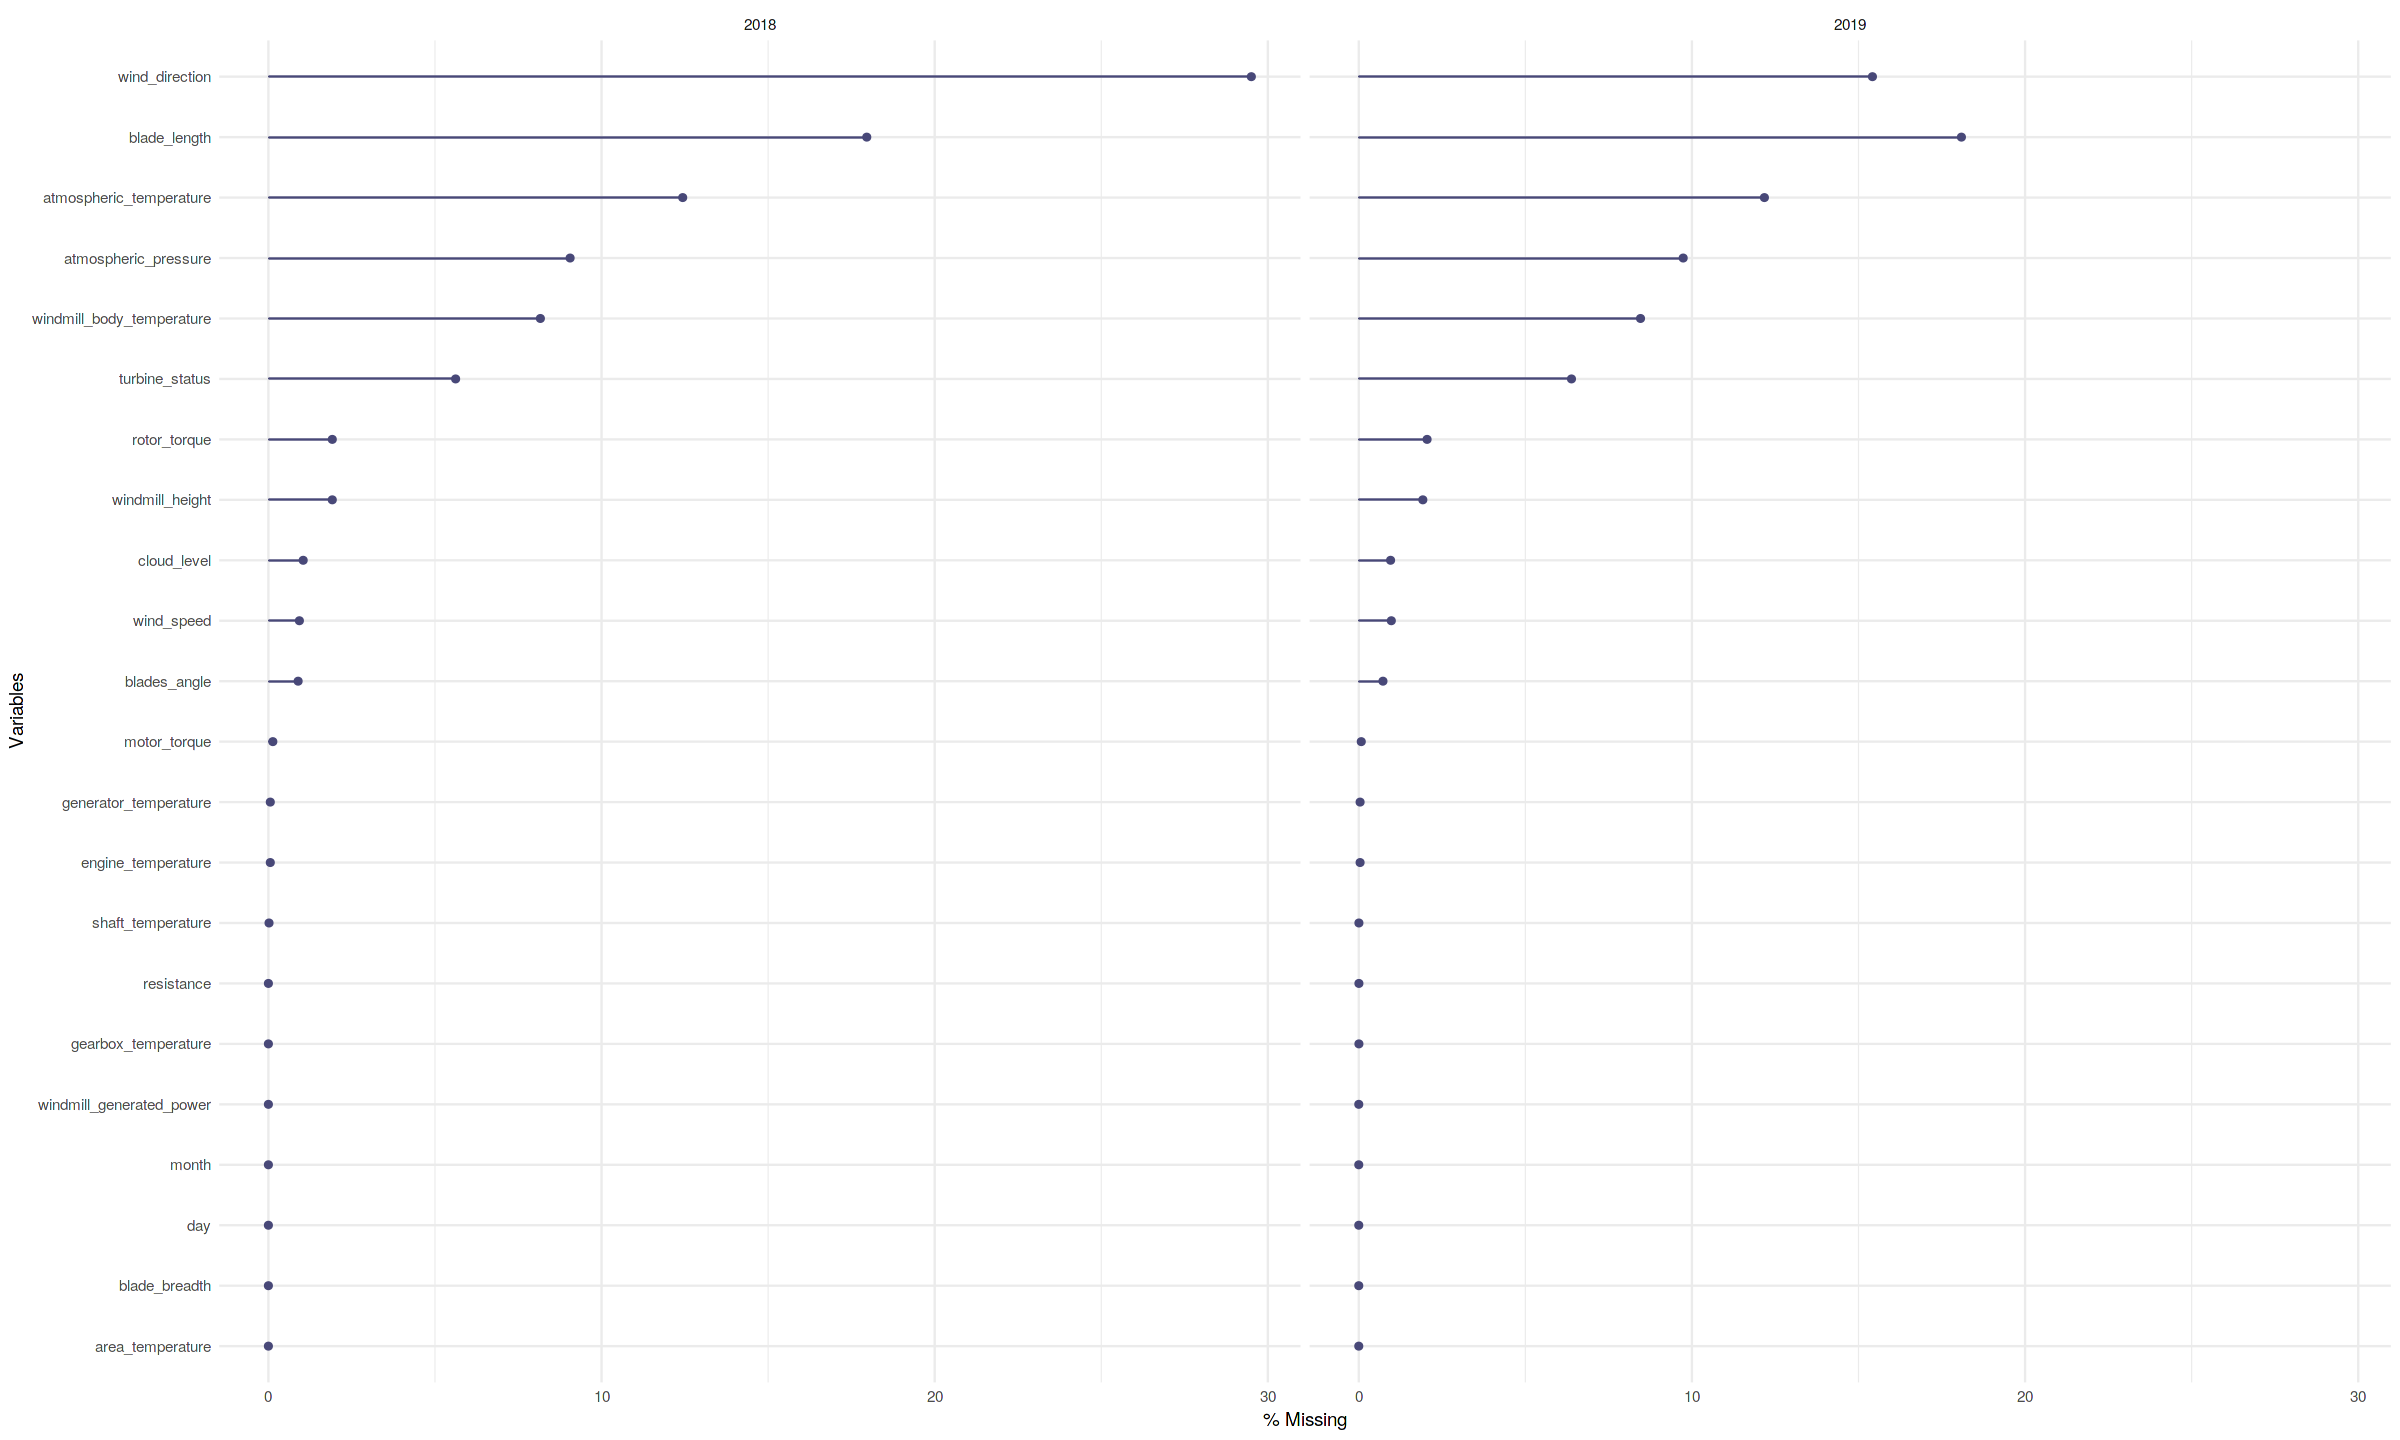

In [9]:
options(repr.plot.width = 20, repr.plot.height = 12)

gg_miss_var(train, facet = year, show_pct = TRUE)

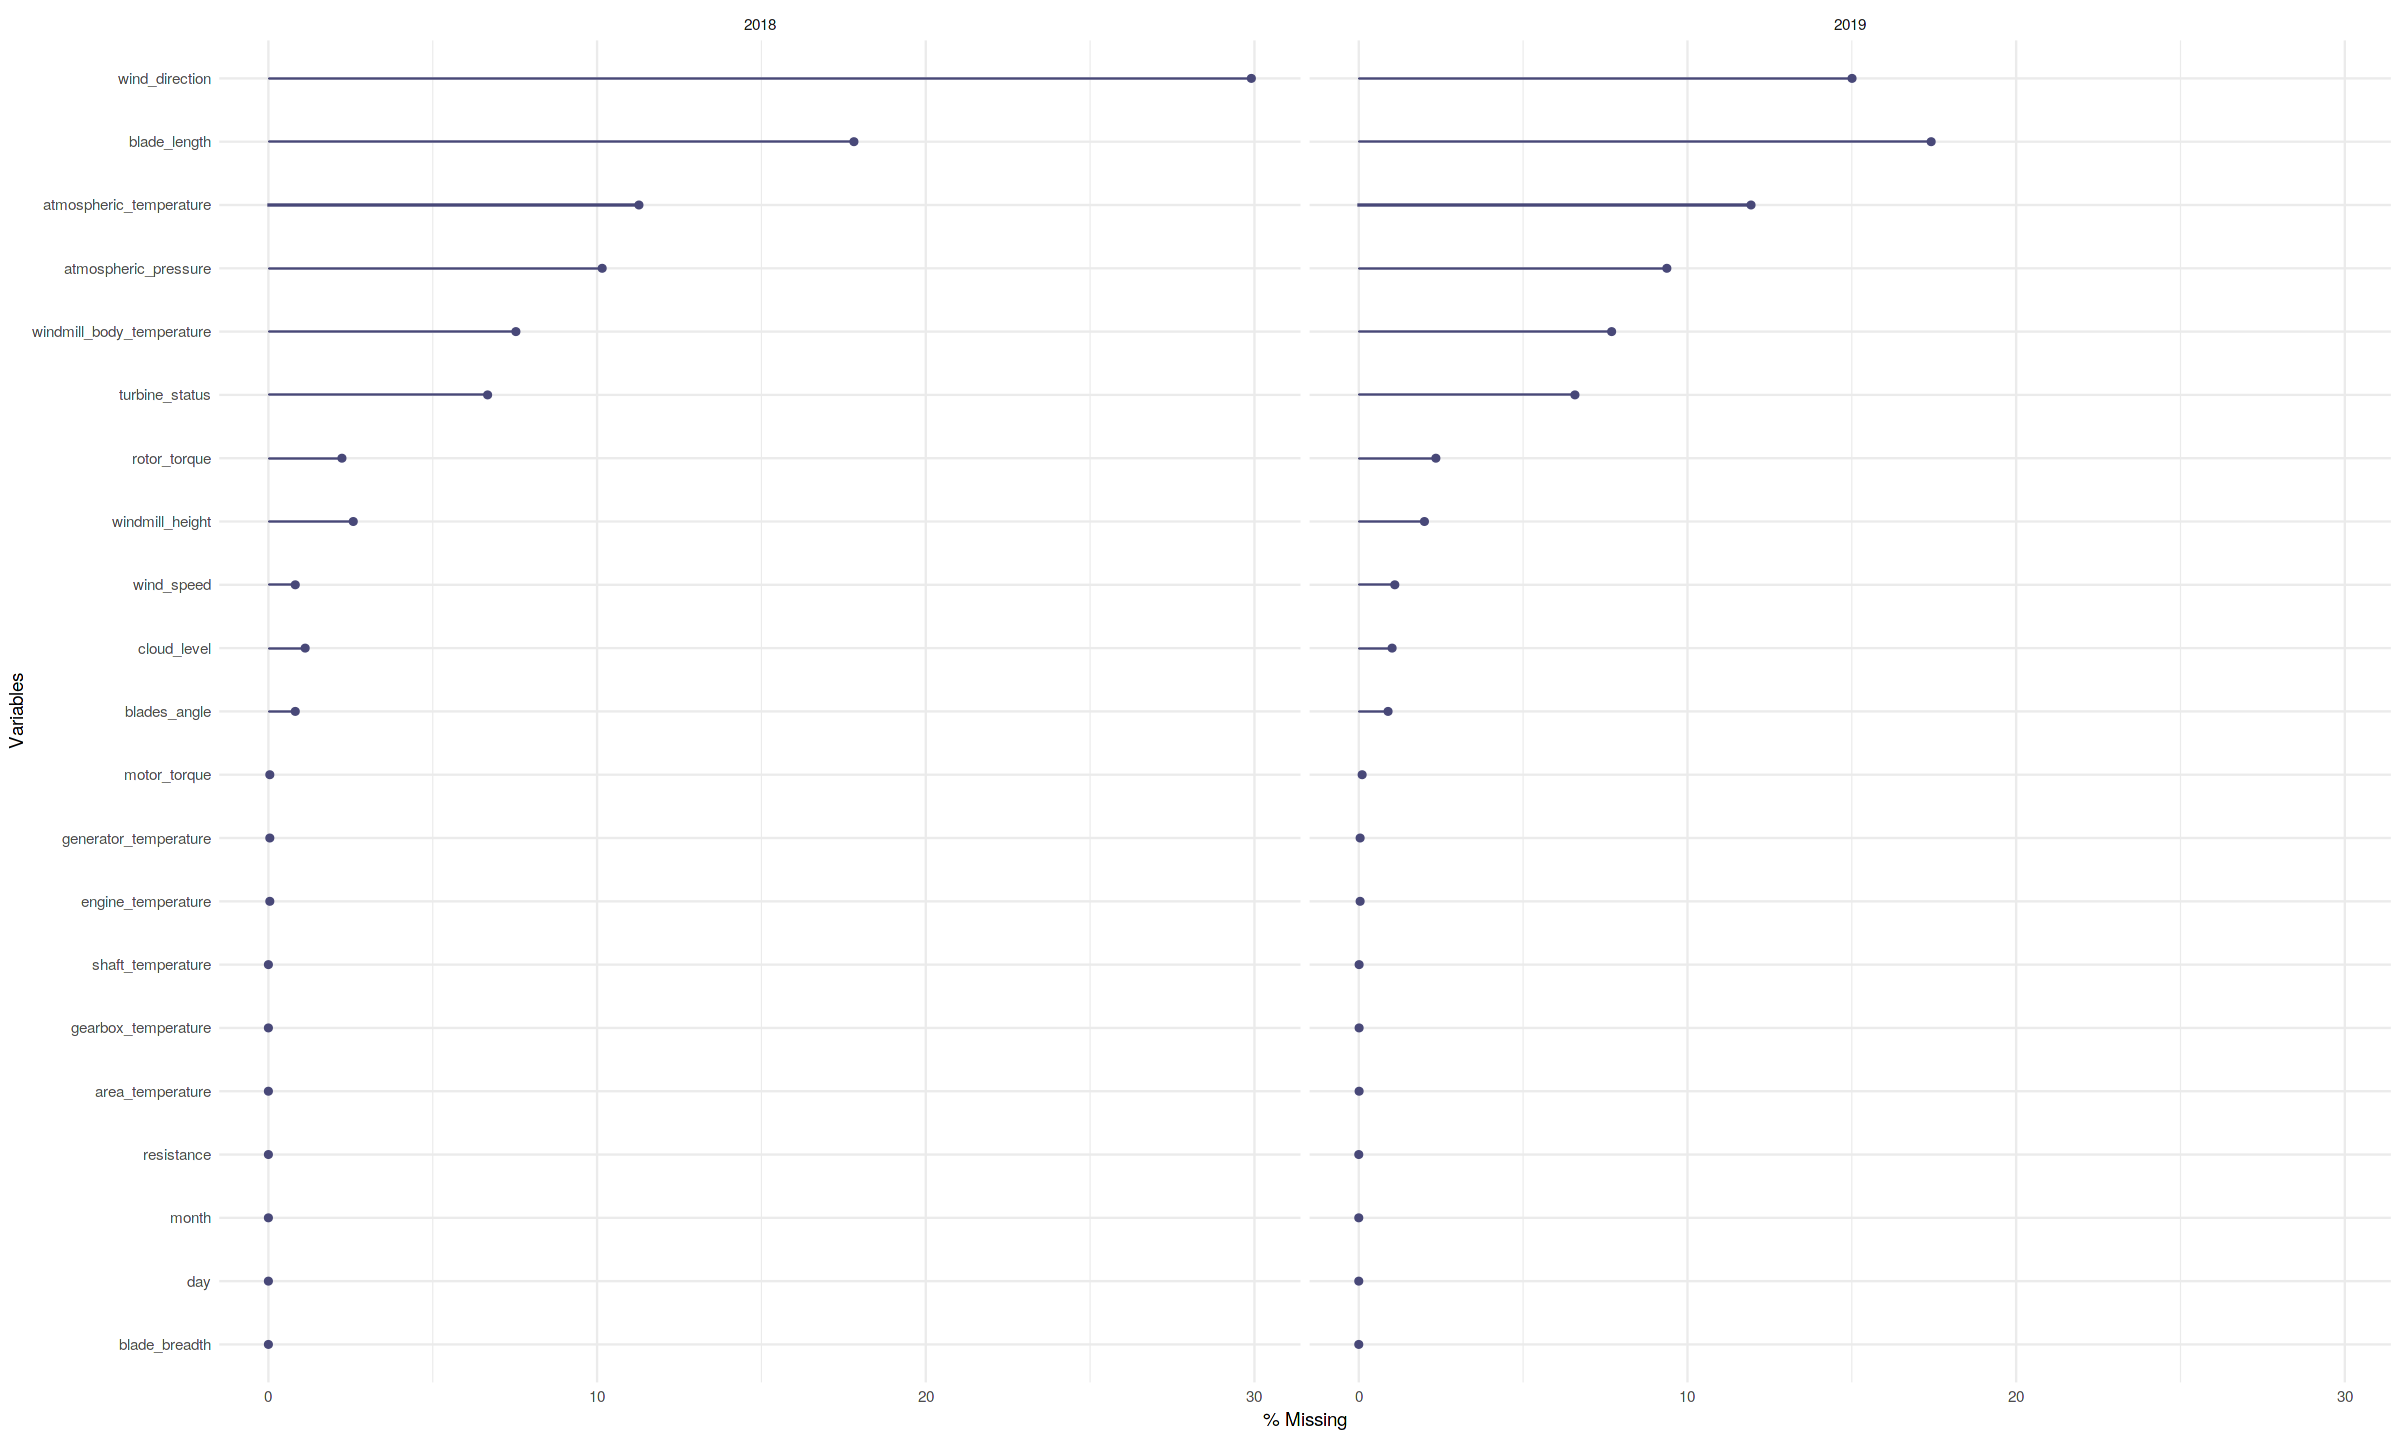

In [10]:
gg_miss_var(test, facet = year, show_pct = TRUE)

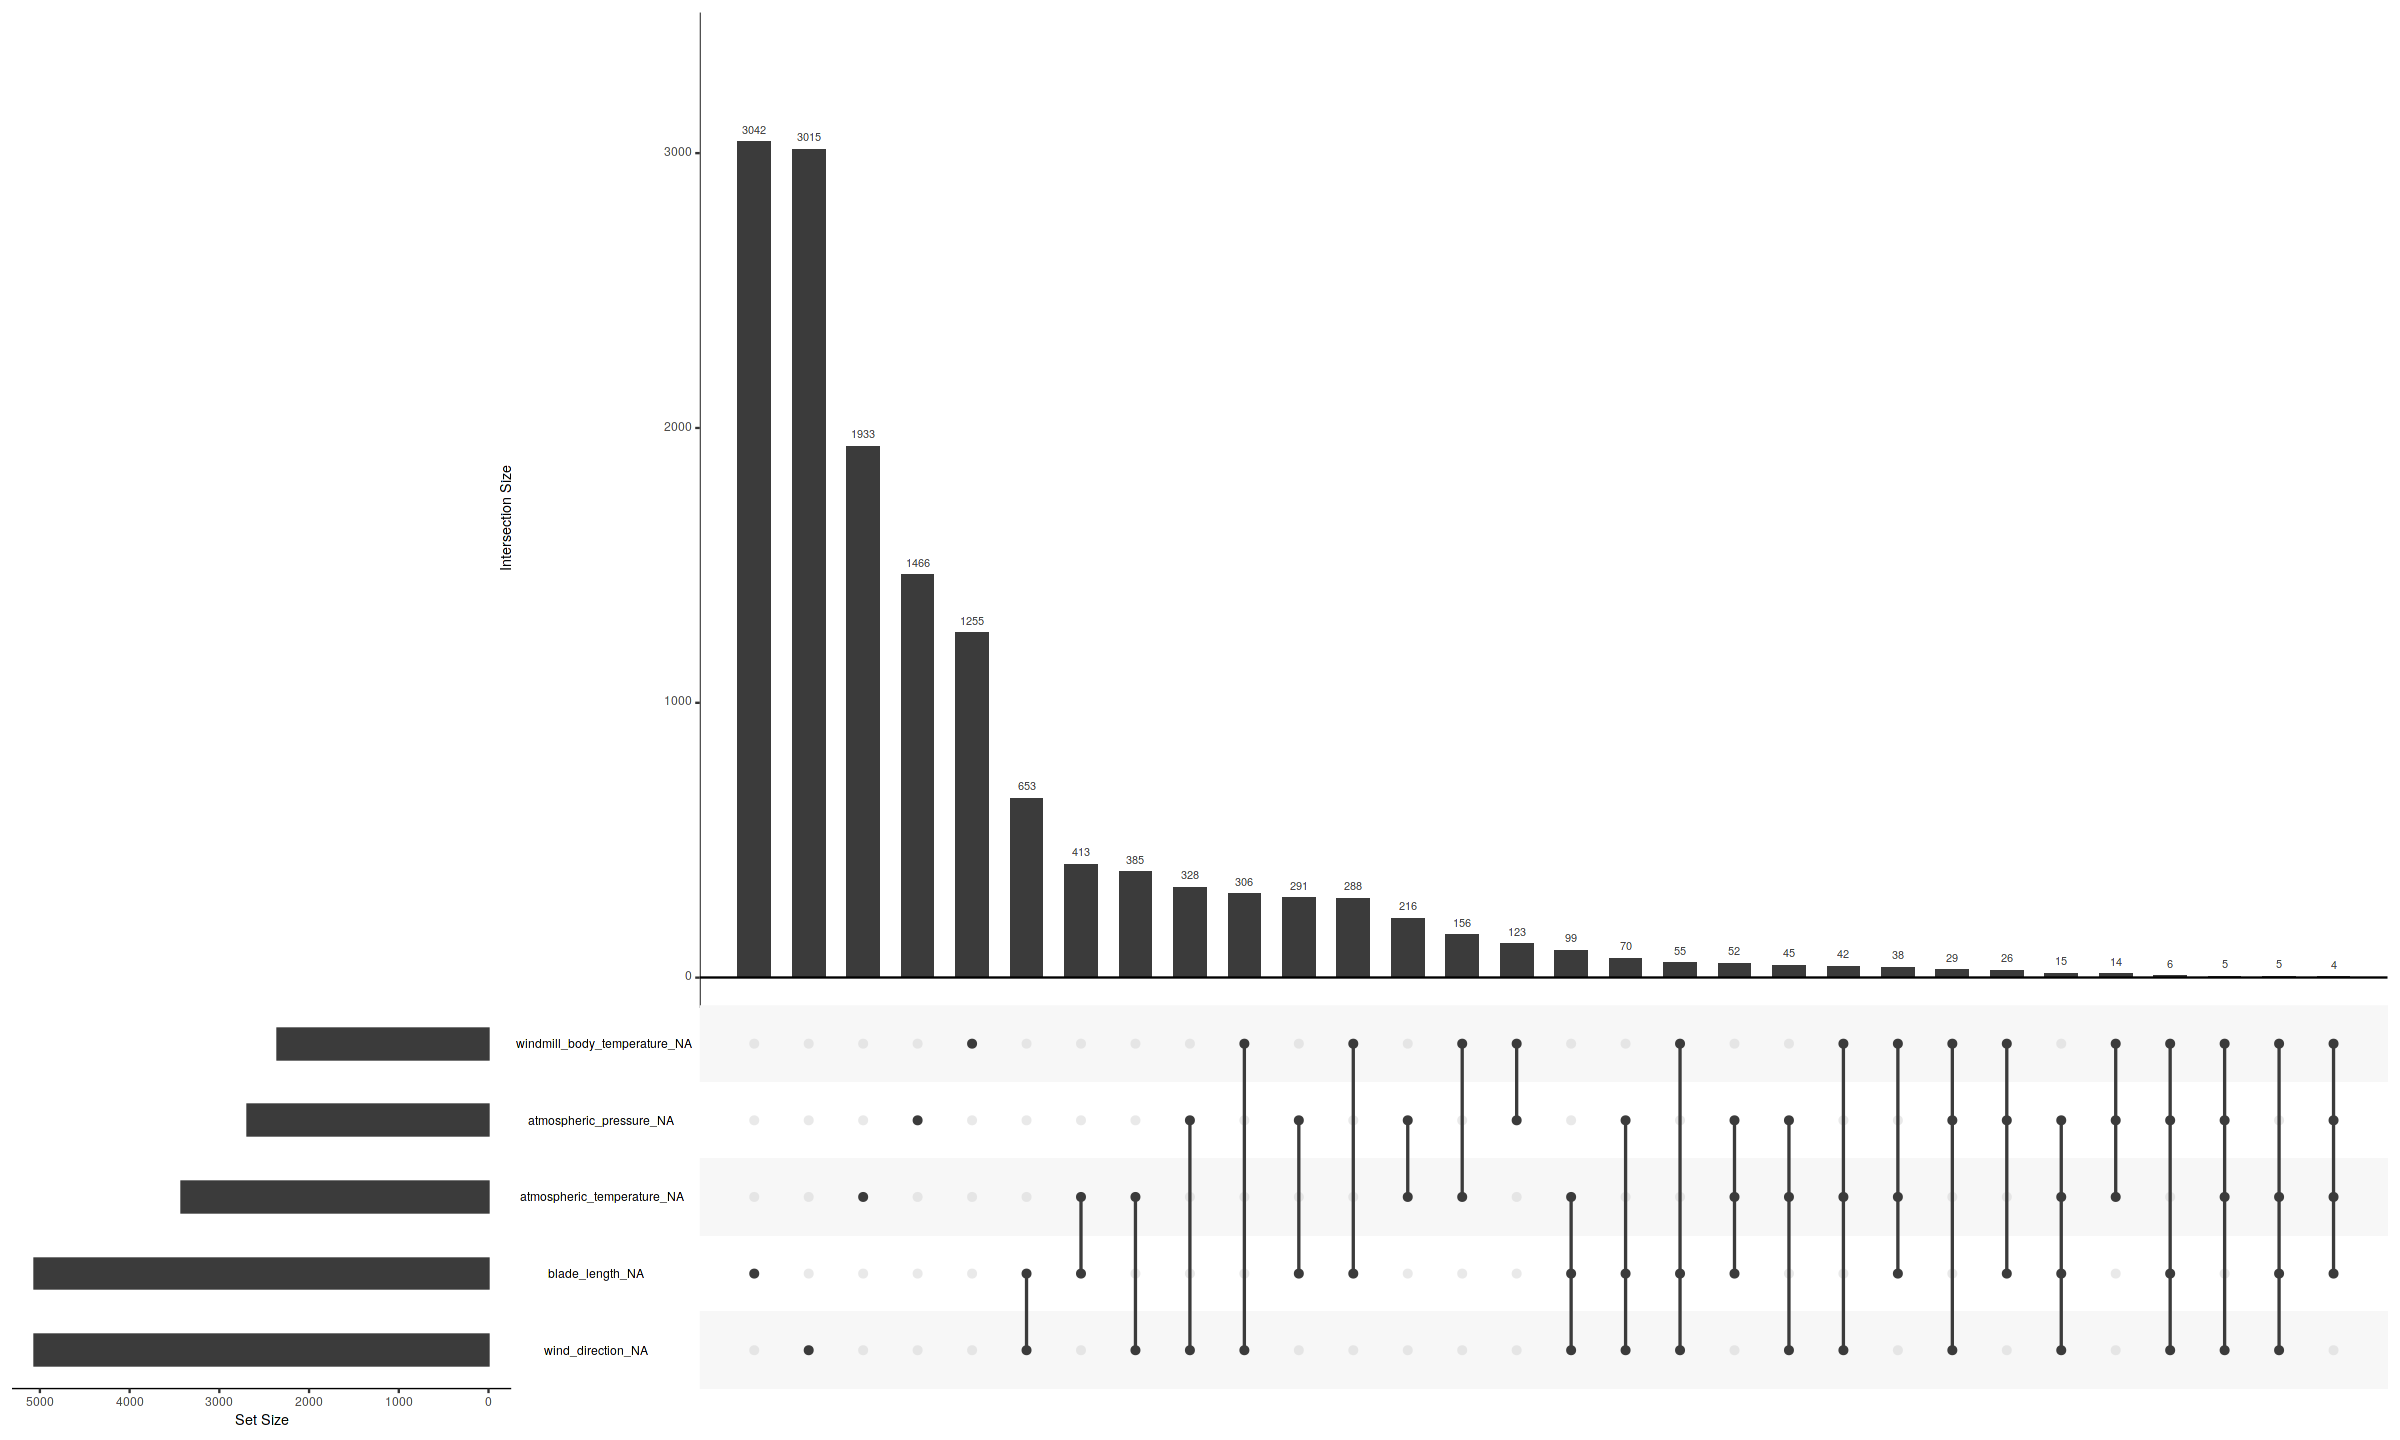

In [11]:
gg_miss_upset(train)

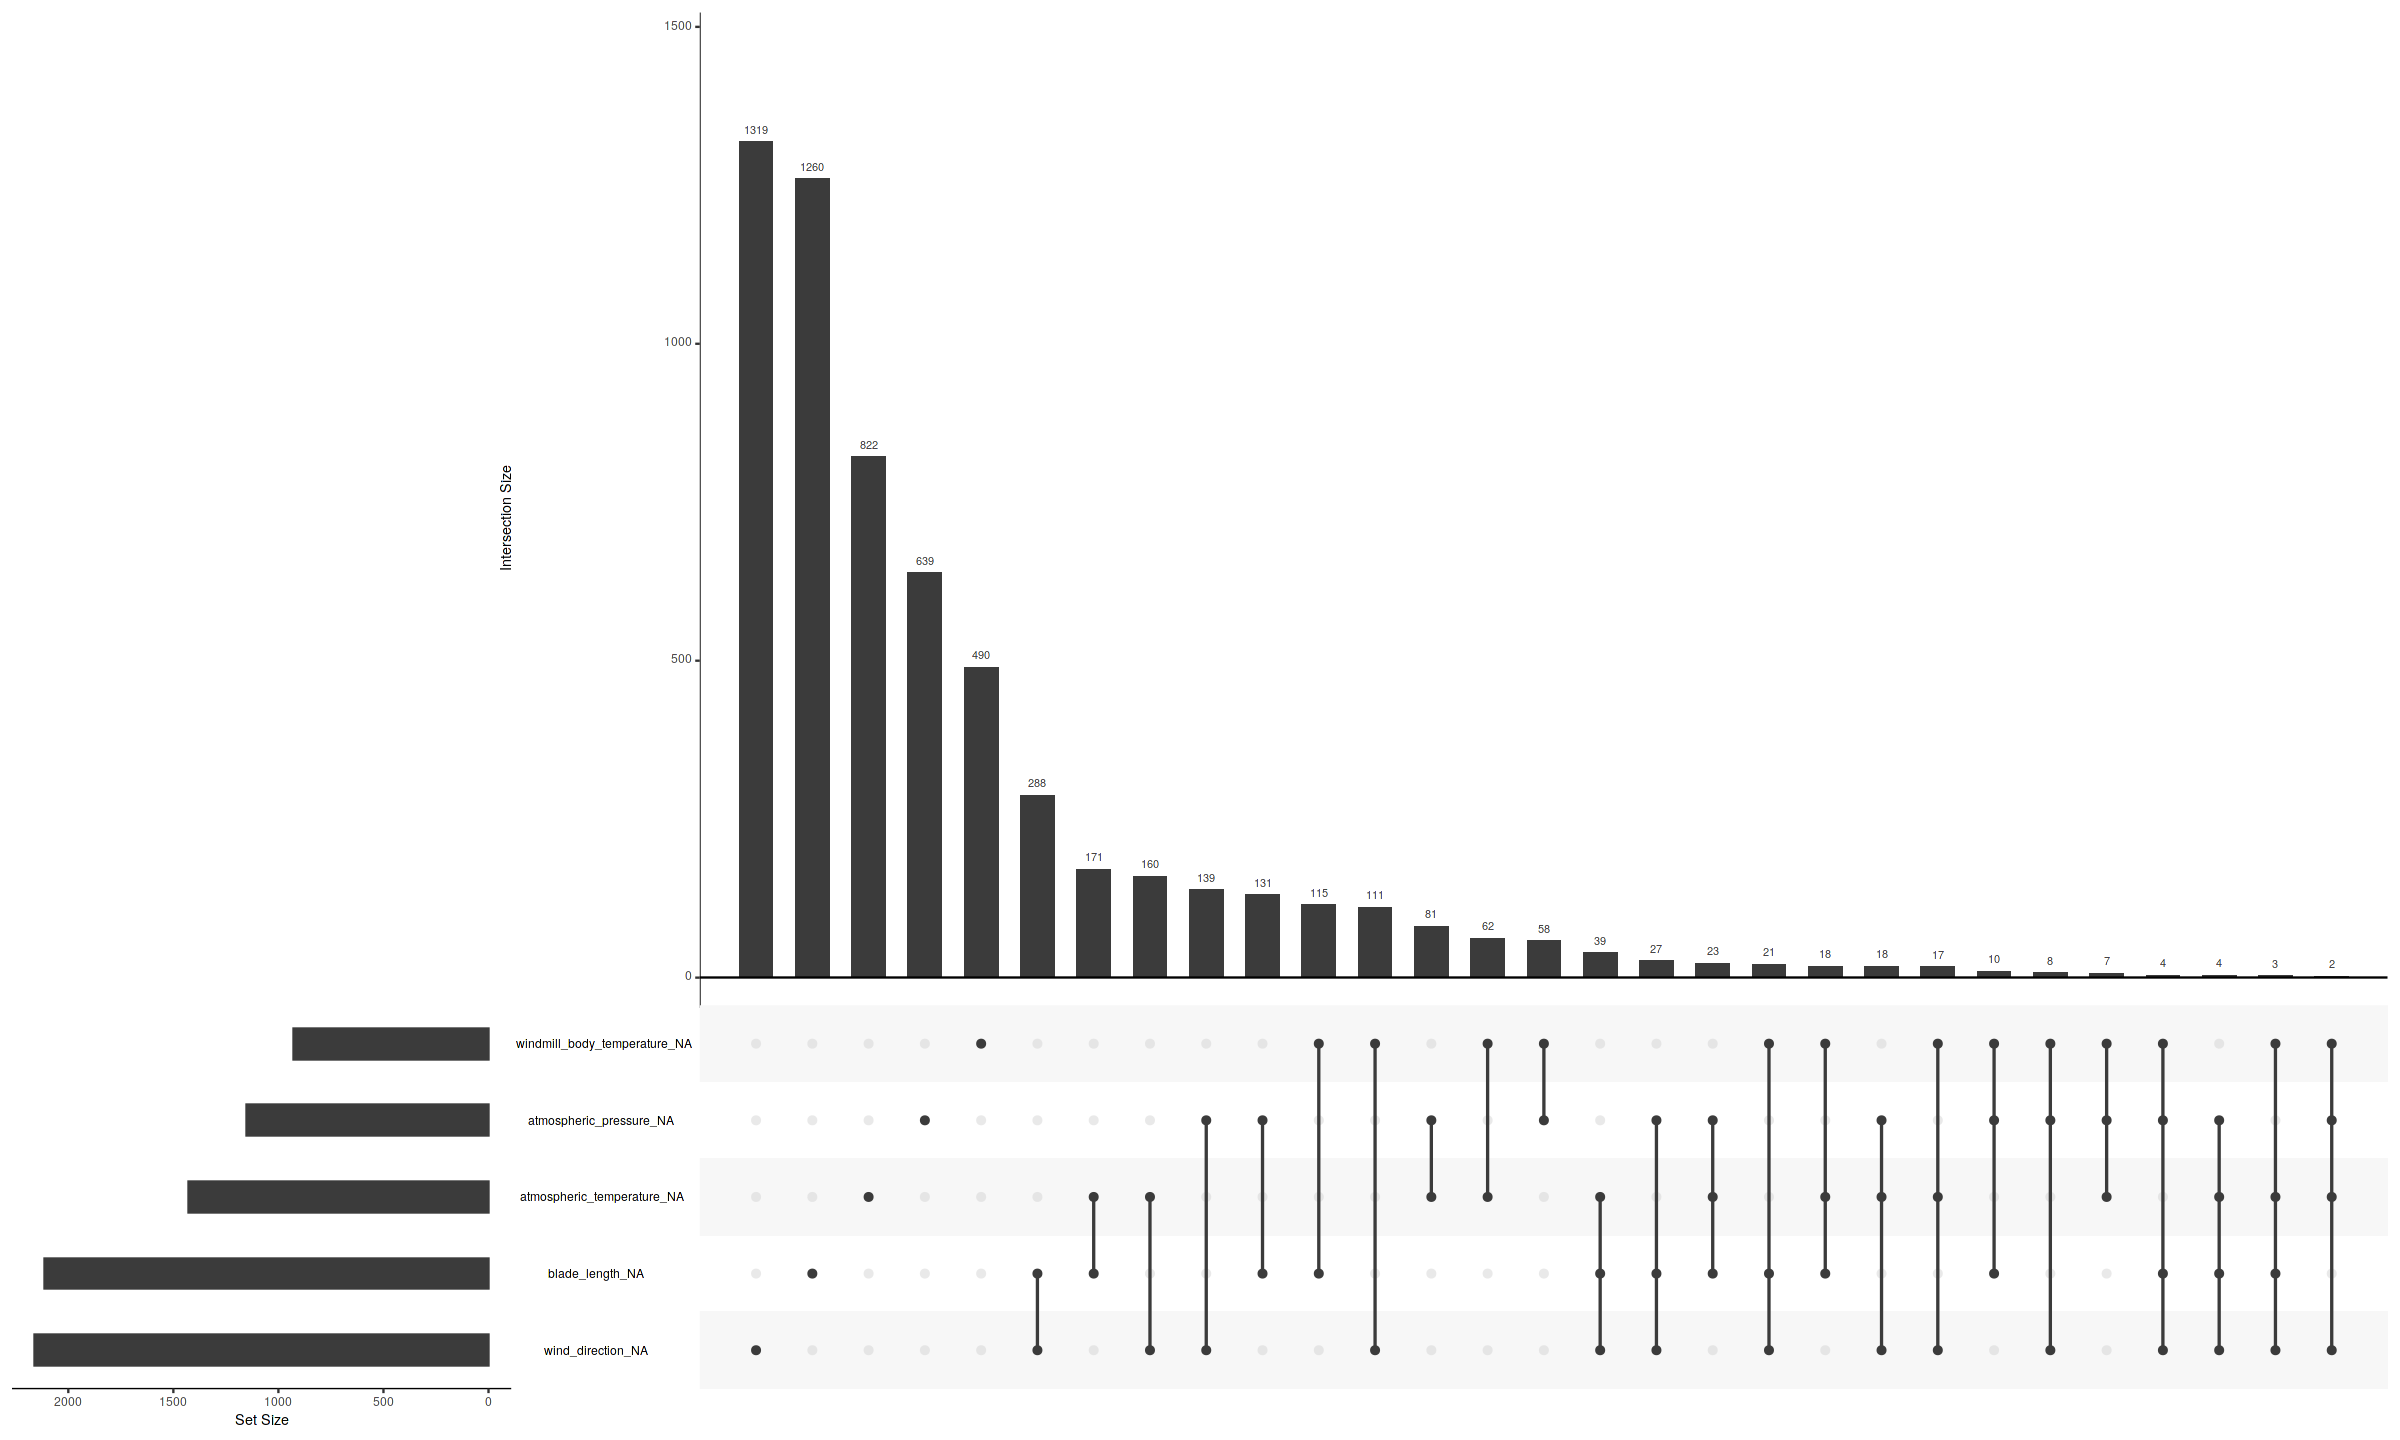

In [12]:
gg_miss_upset(test)

### 3. Monthwise Generated Power w.r.t Day

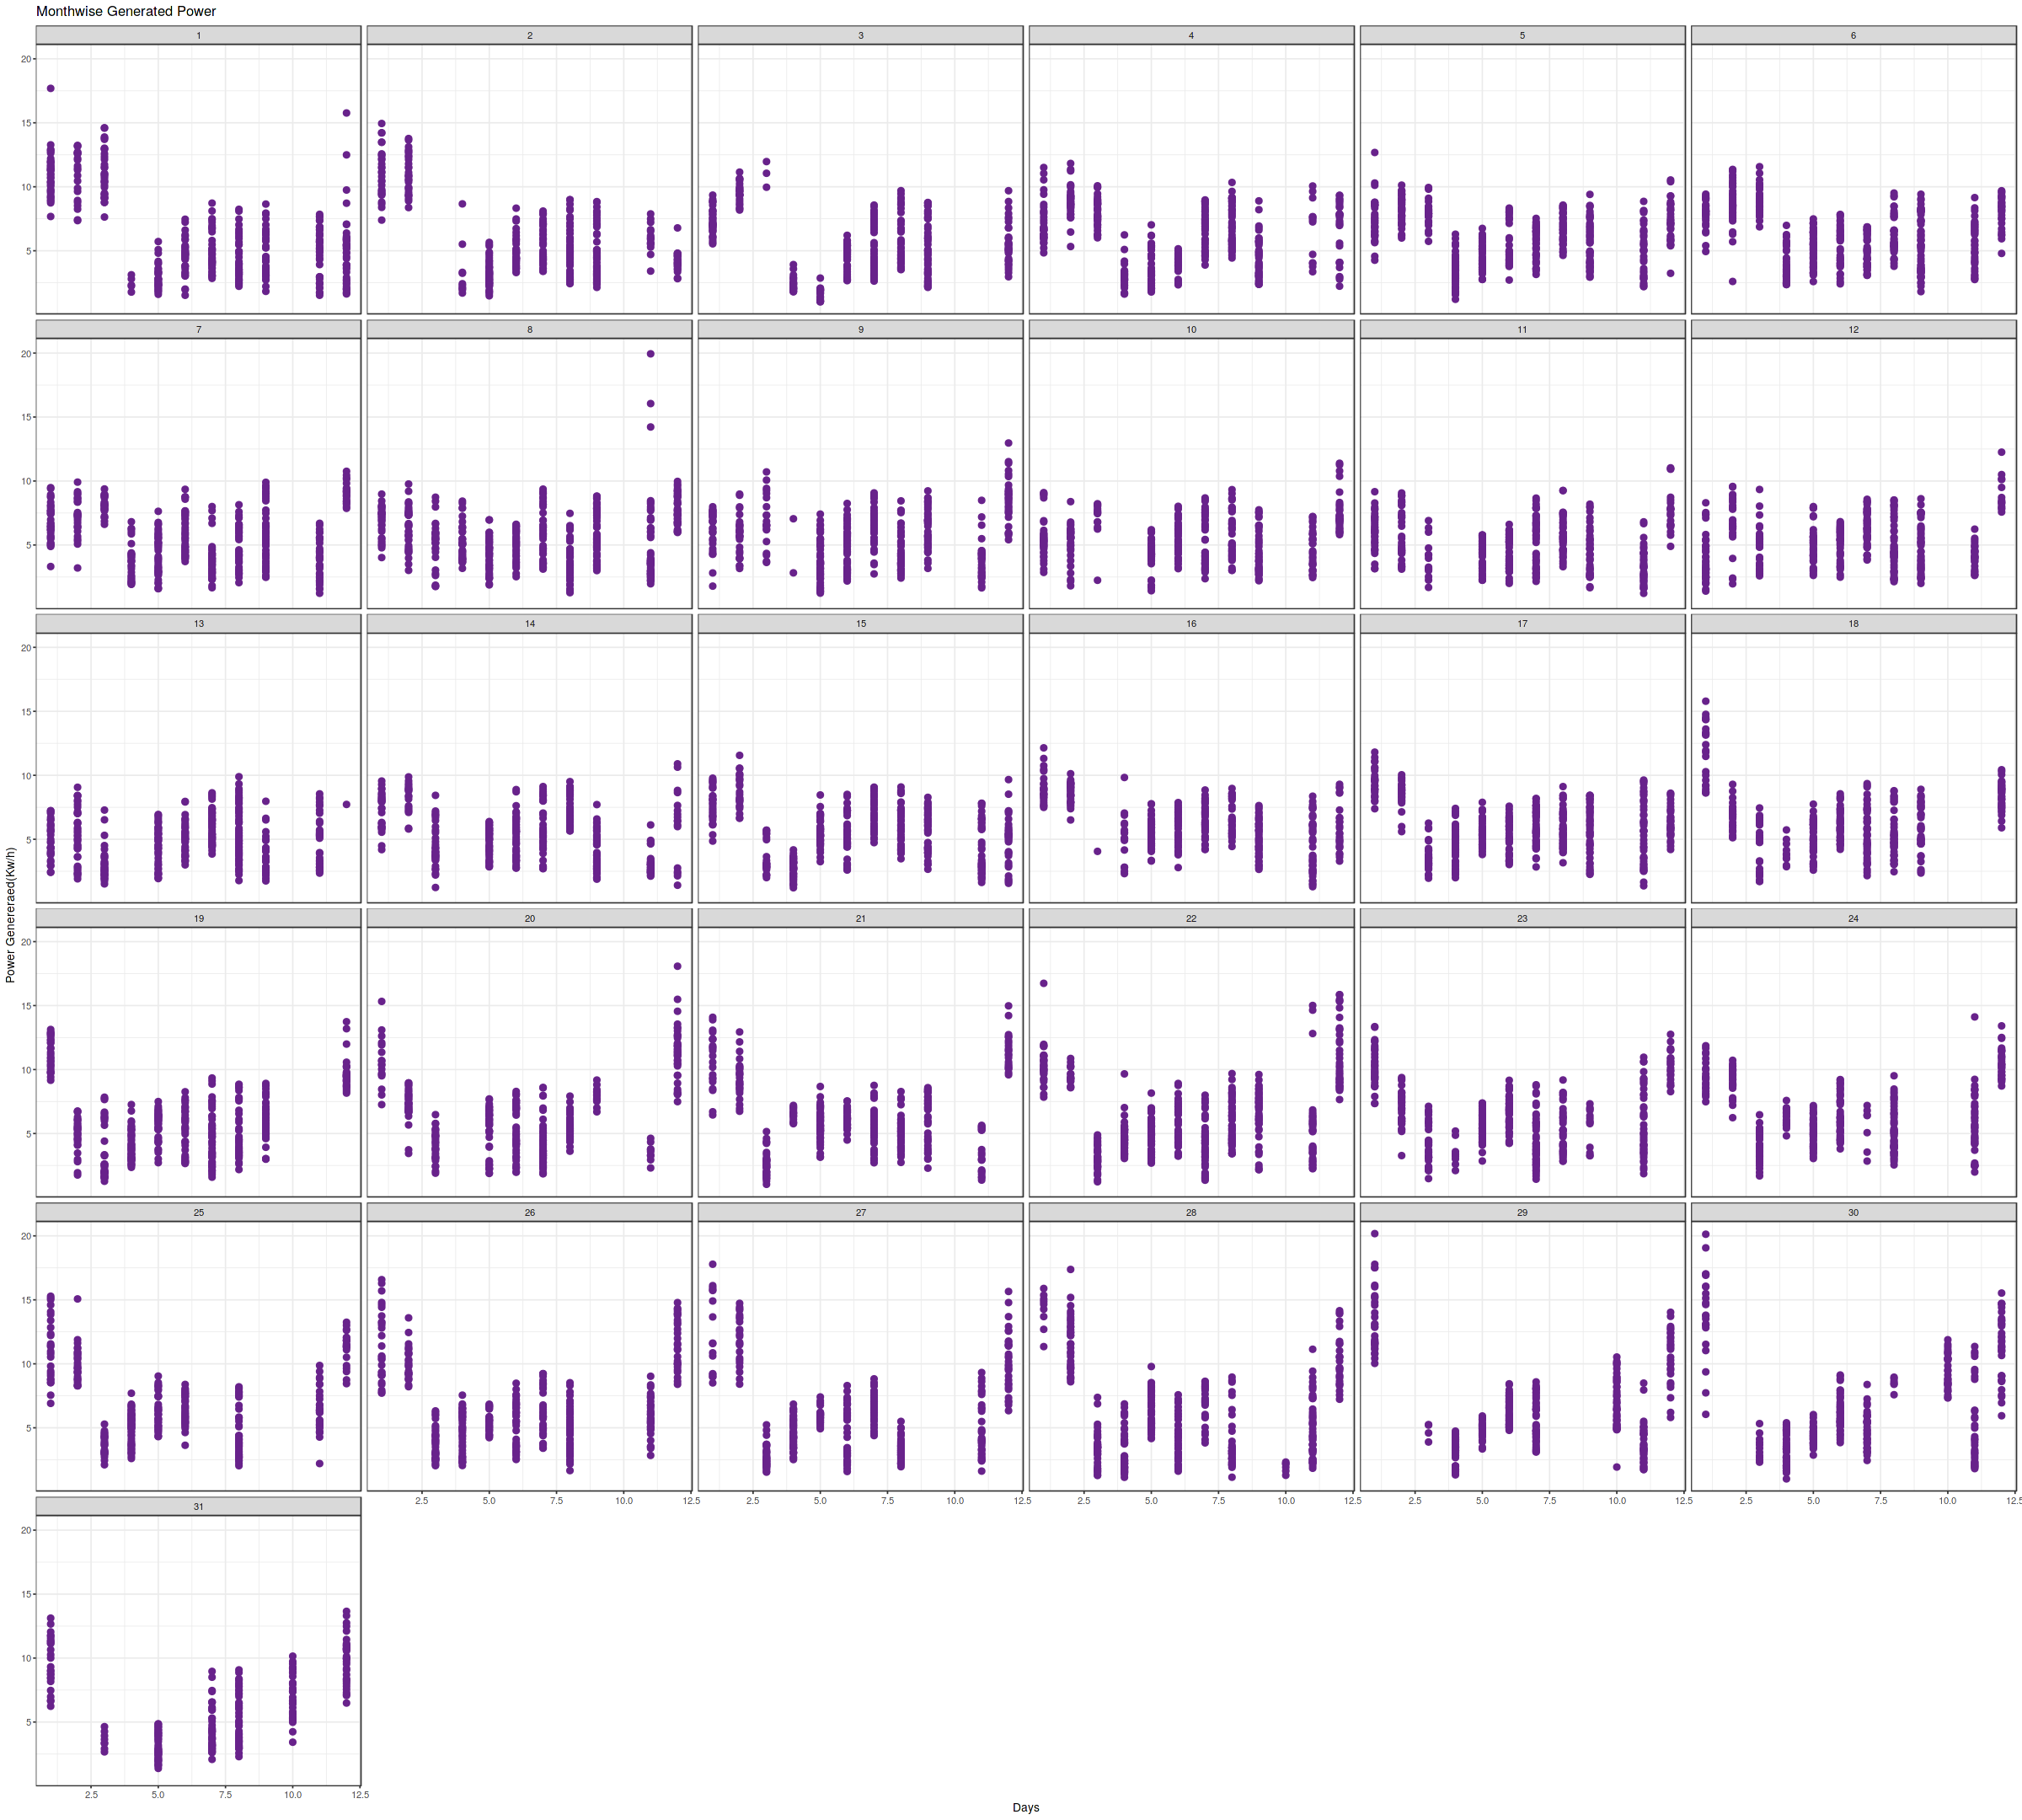

In [13]:
options(repr.plot.width = 20, repr.plot.height = 18)

na.omit(train) %>%
  ggplot(aes(x = month, y = windmill_generated_power)) +
  geom_point(color = "darkorchid4") +
  labs(title = "Monthwise Generated Power",
       y = "Power Genereraed(Kw/h)",
       x = "Days") + theme_bw(base_size = 8) + facet_wrap(~day) 

### 4. Analysing all the Numeric Features

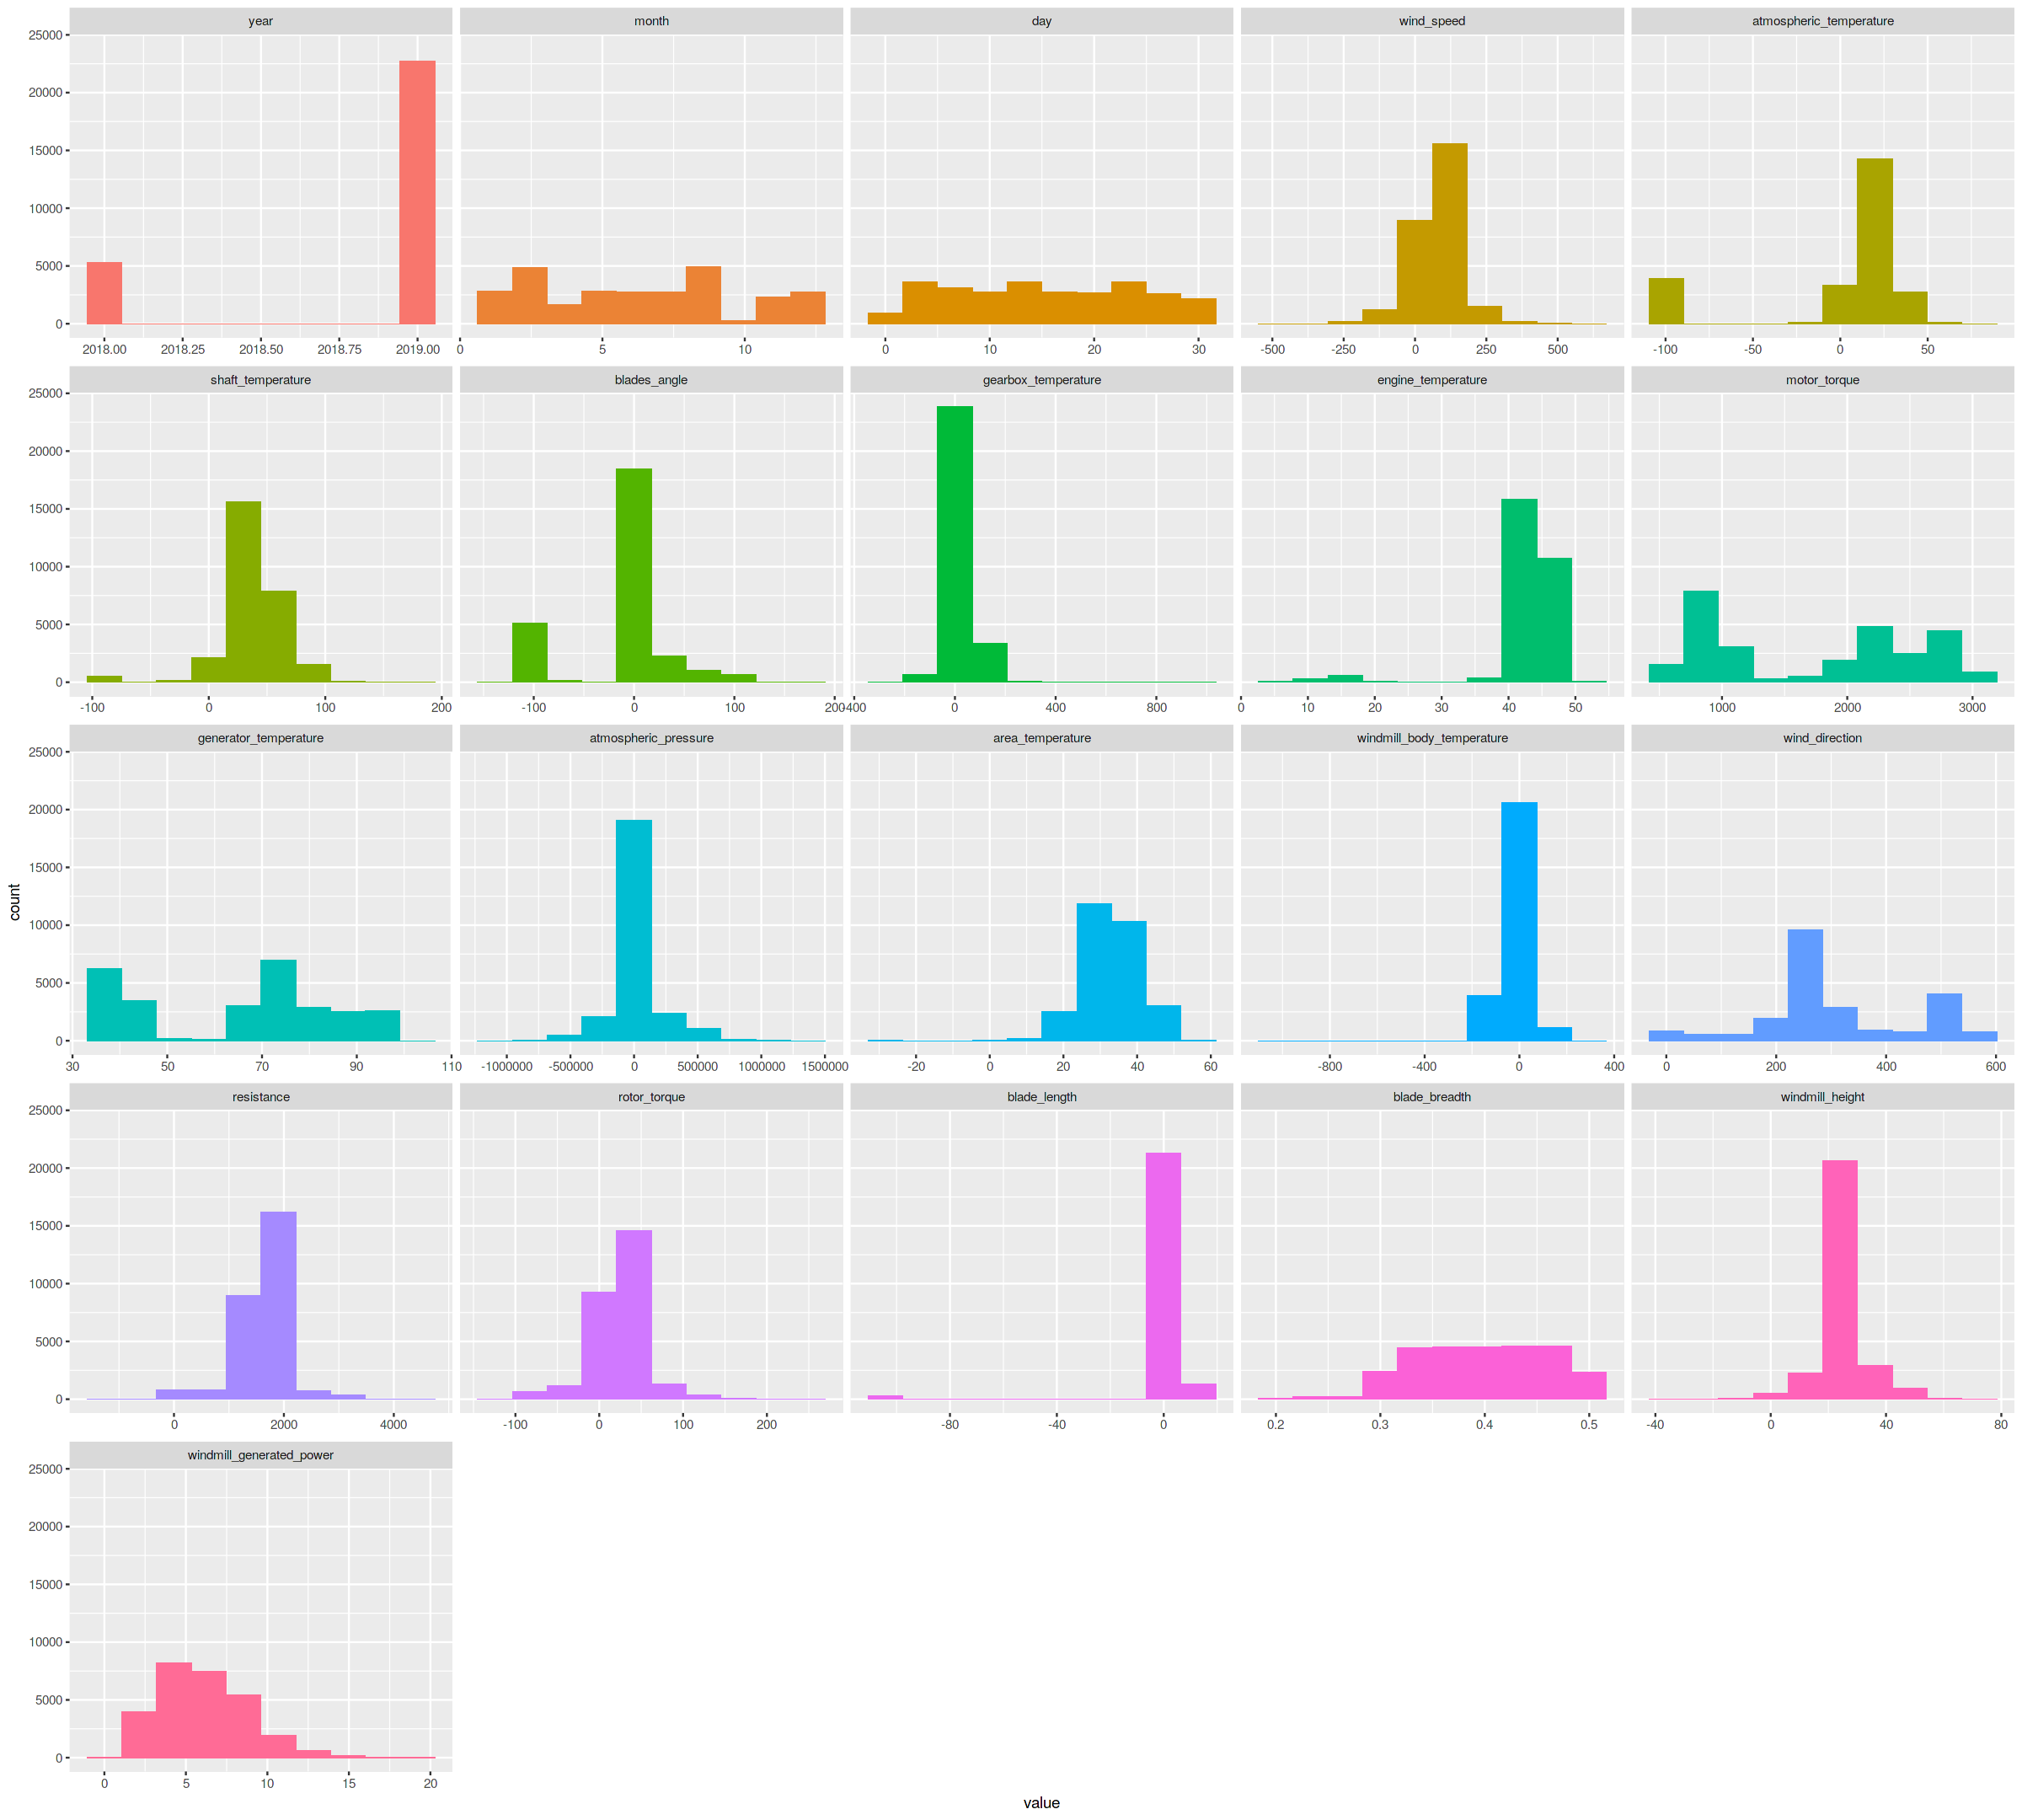

In [14]:
plot_num(train)

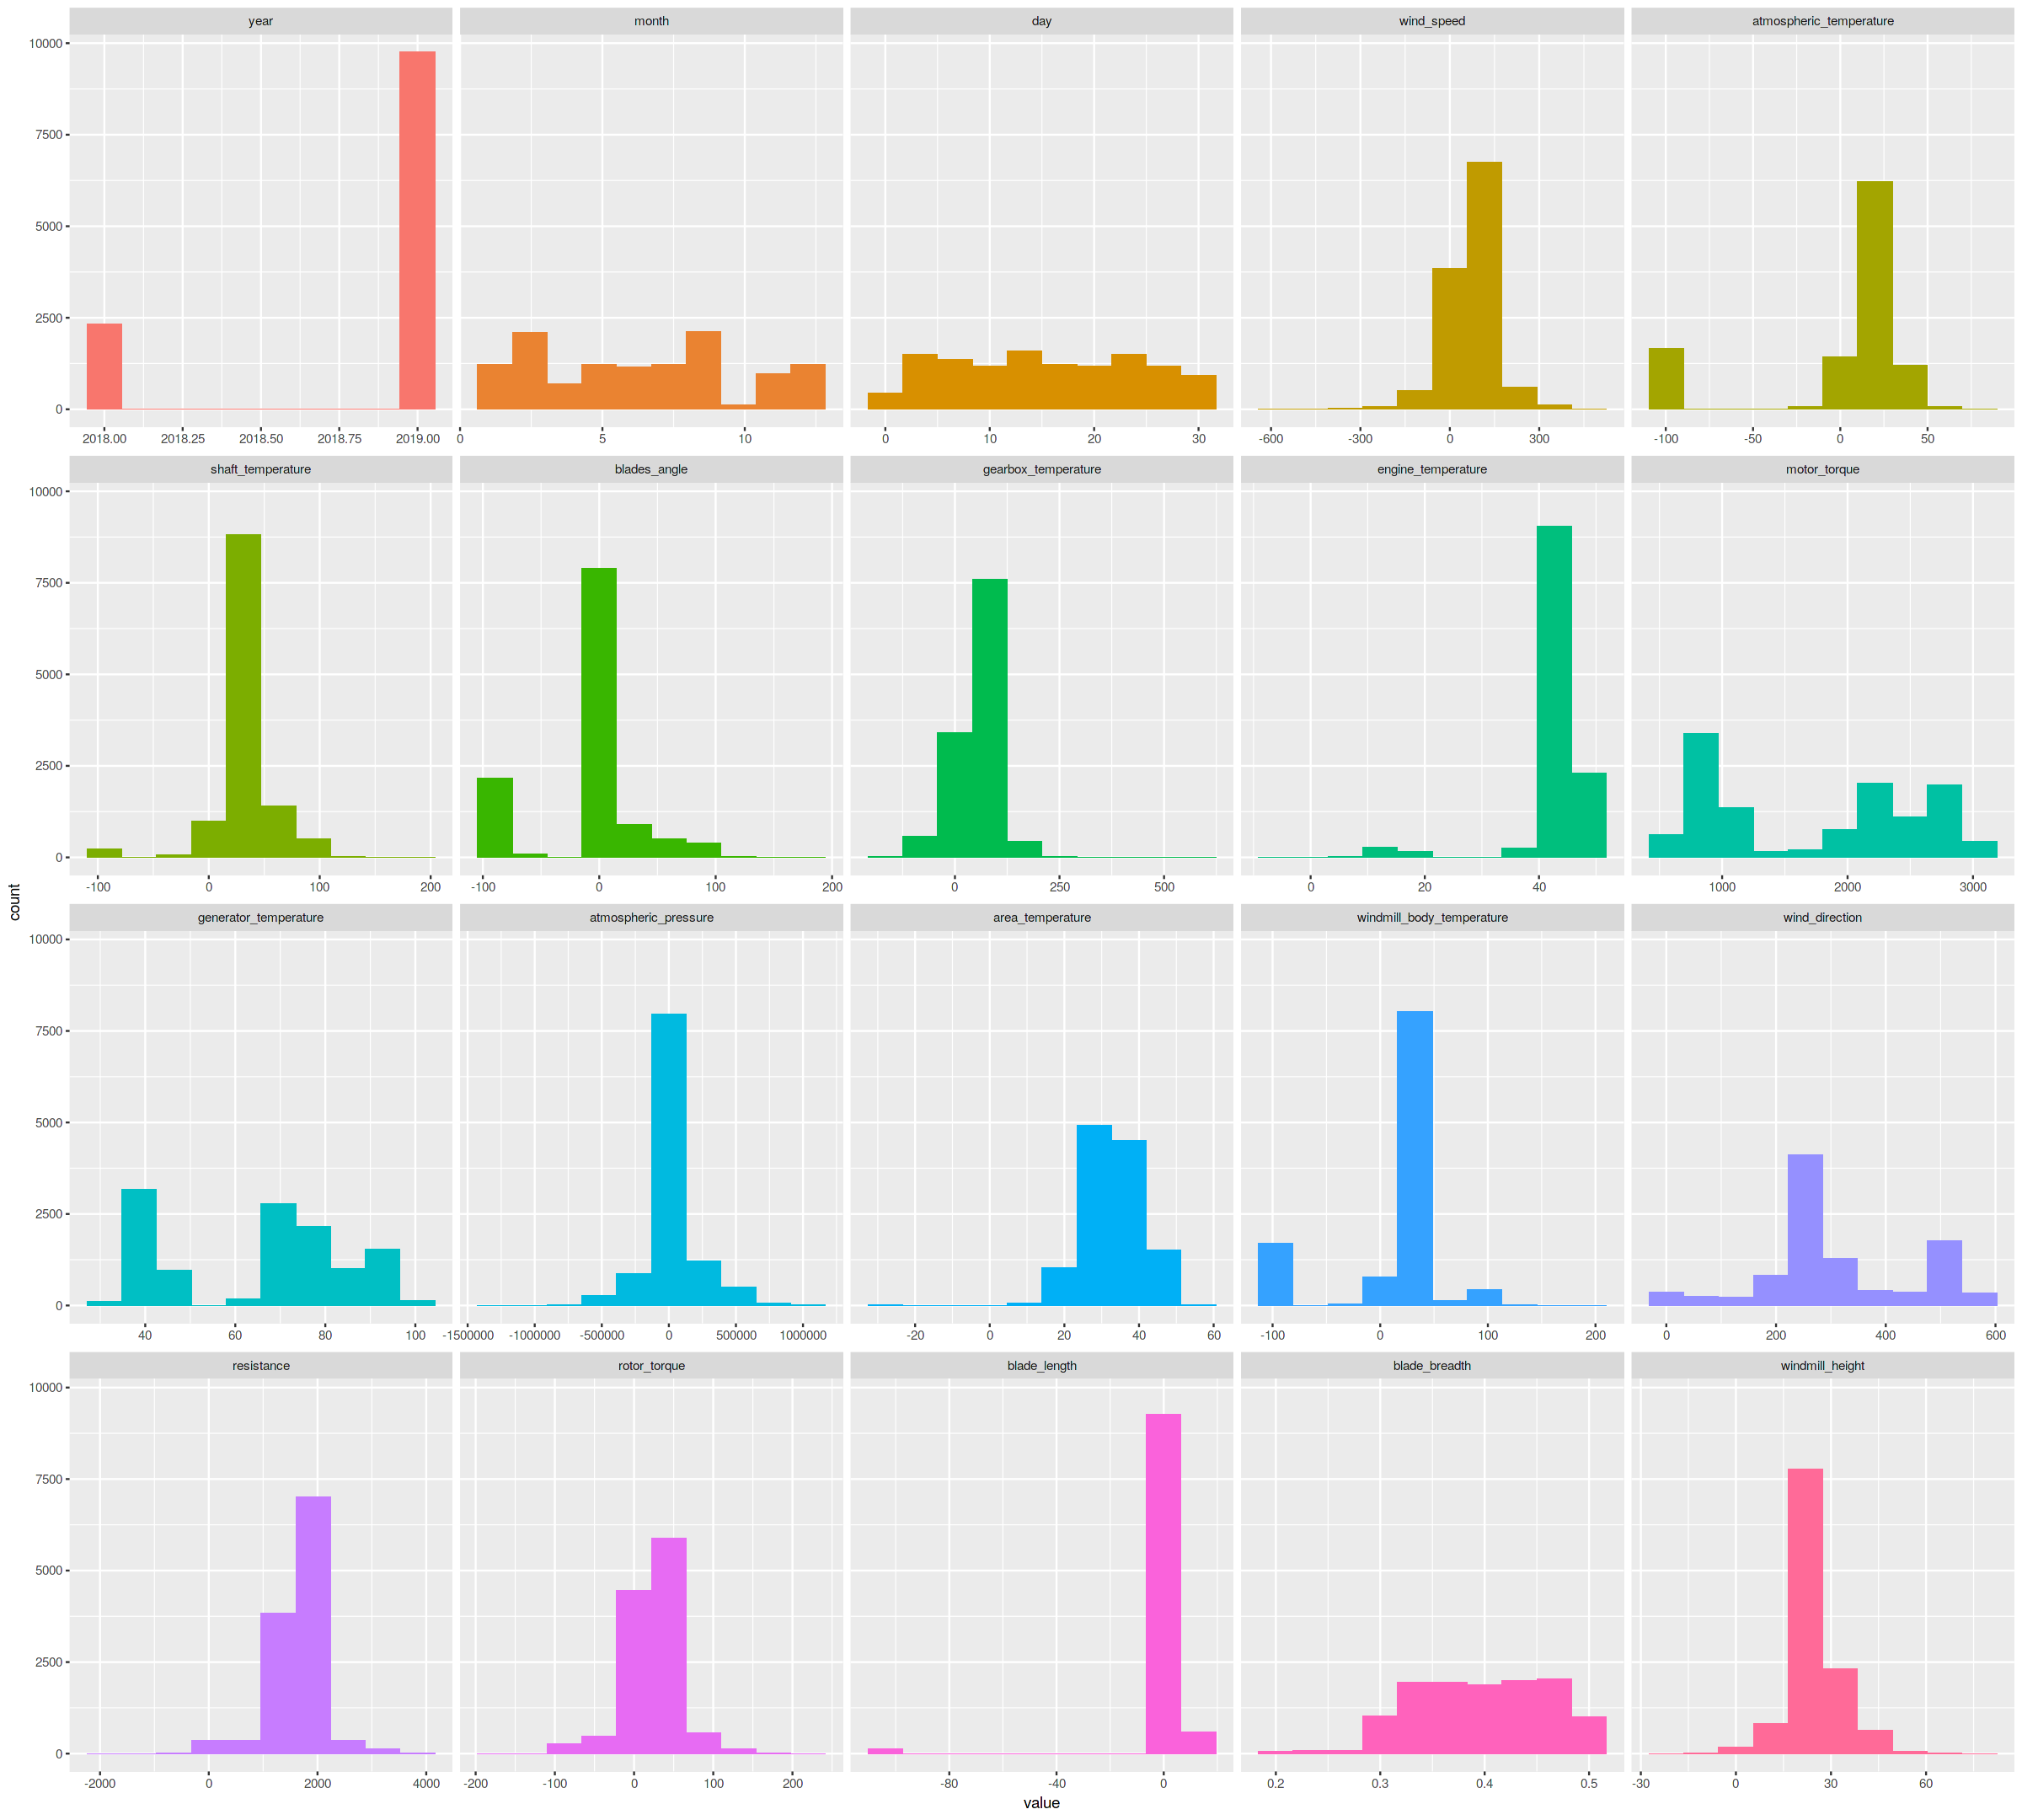

In [15]:
plot_num(test)

### 5. Analysing all the Categorical Features

   turbine_status frequency percentage cumulative_perc
1              BB      1930       6.89            6.89
2             AAA      1925       6.88           13.77
3             BCB      1920       6.86           20.63
4              B2      1918       6.85           27.48
5               A      1914       6.84           34.32
6               D      1907       6.81           41.13
7               B      1870       6.68           47.81
8              AB      1855       6.63           54.44
9             ABC      1855       6.63           61.07
10             AC      1841       6.58           67.65
11             A2      1840       6.57           74.22
12             BA      1835       6.56           80.78
13             BD      1830       6.54           87.32
14            BBB      1806       6.45           93.77
15           <NA>      1747       6.24          100.00



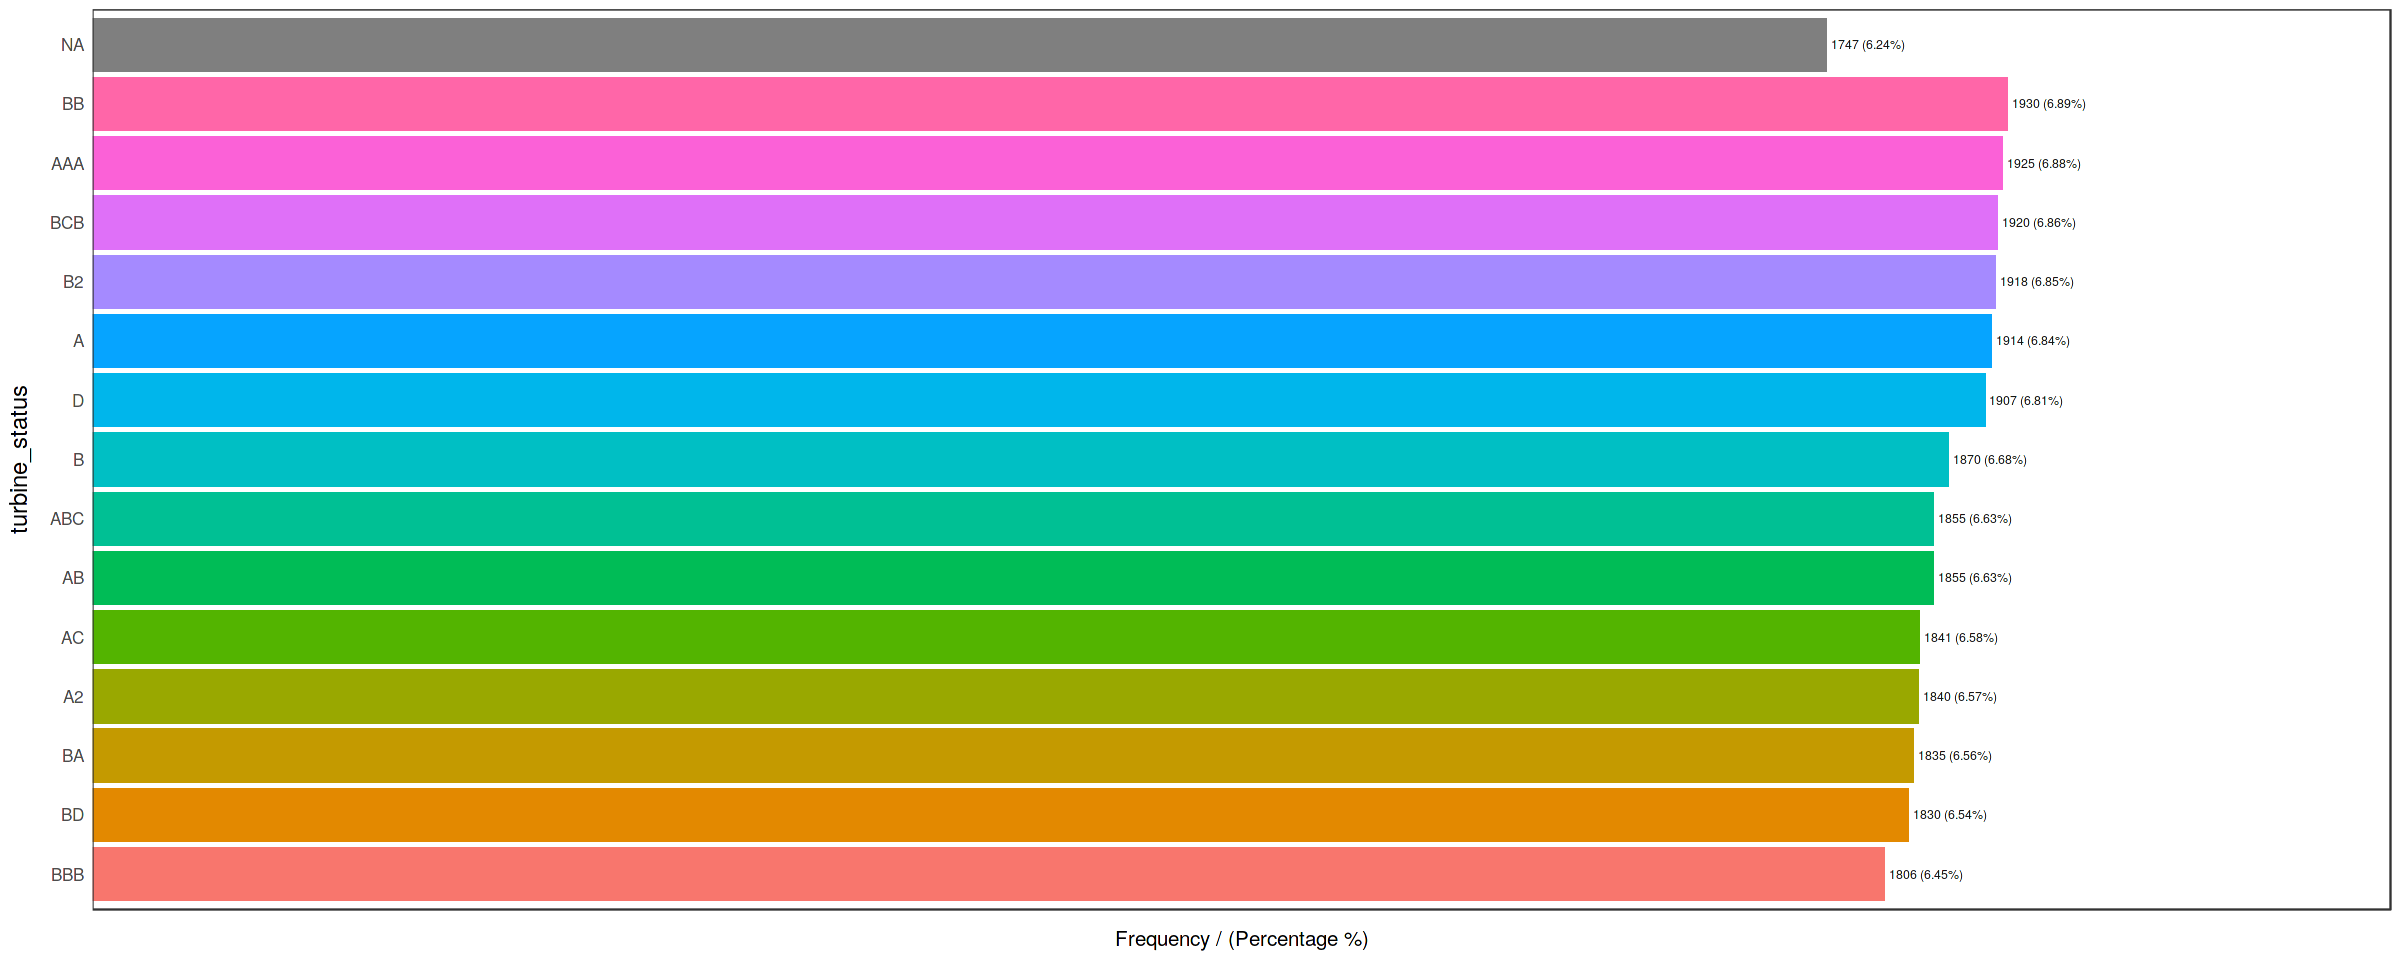

    cloud_level frequency percentage cumulative_perc
1           Low     13824      49.38           49.38
2        Medium     13598      48.58           97.96
3 Extremely Low       299       1.07           99.03
4          <NA>       272       0.97          100.00



[1] "Variables processed: turbine_status, cloud_level"

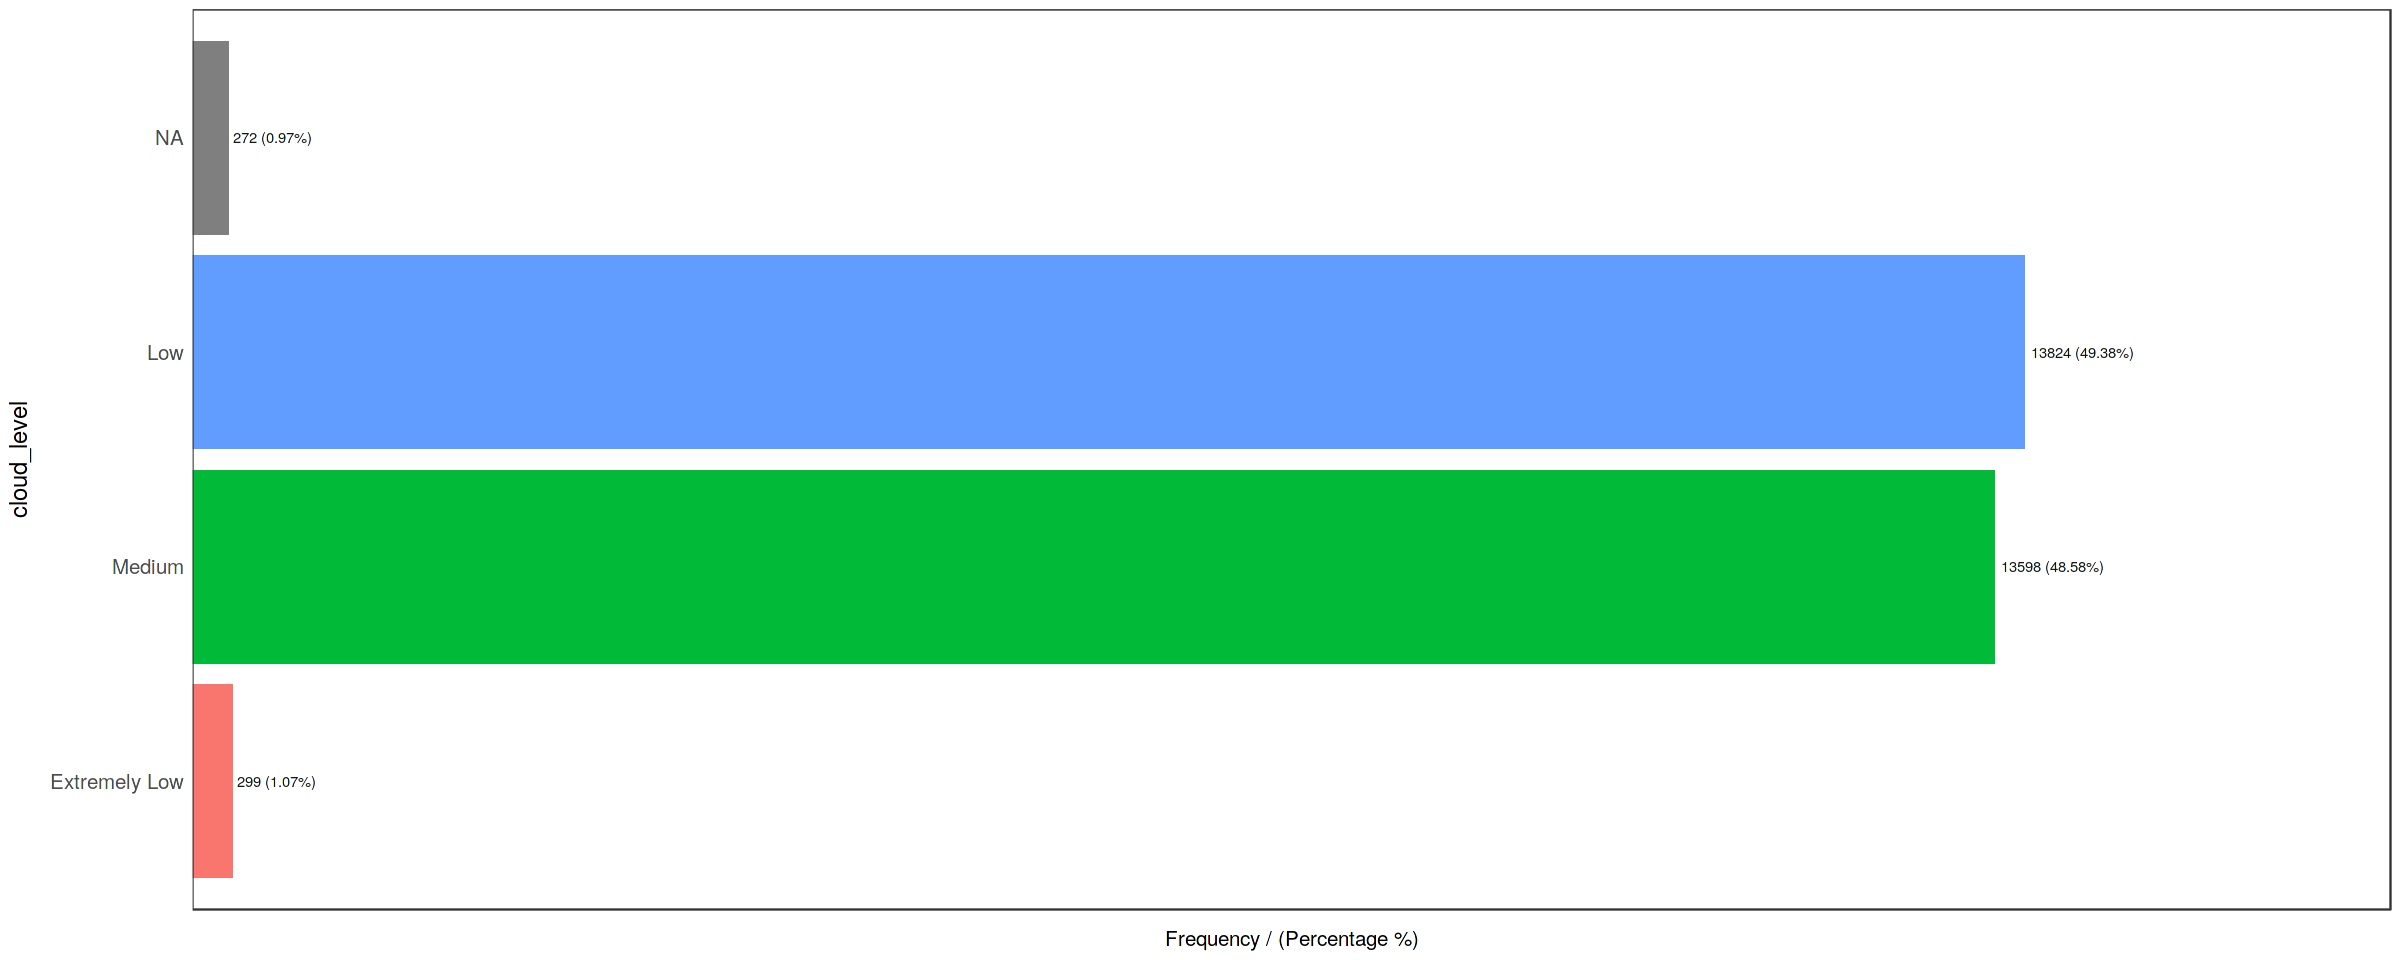

In [16]:
options(repr.plot.width = 20, repr.plot.height = 8)

freq(train)

   turbine_status frequency percentage cumulative_perc
1              BB       871       7.21            7.21
2              B2       859       7.11           14.32
3               A       852       7.05           21.37
4             BBB       813       6.73           28.10
5             BCB       811       6.71           34.81
6              BA       809       6.69           41.50
7              AB       804       6.65           48.15
8            <NA>       797       6.59           54.74
9              A2       796       6.59           61.33
10            ABC       787       6.51           67.84
11             BD       787       6.51           74.35
12              D       786       6.50           80.85
13             AC       778       6.44           87.29
14            AAA       773       6.40           93.69
15              B       763       6.31          100.00



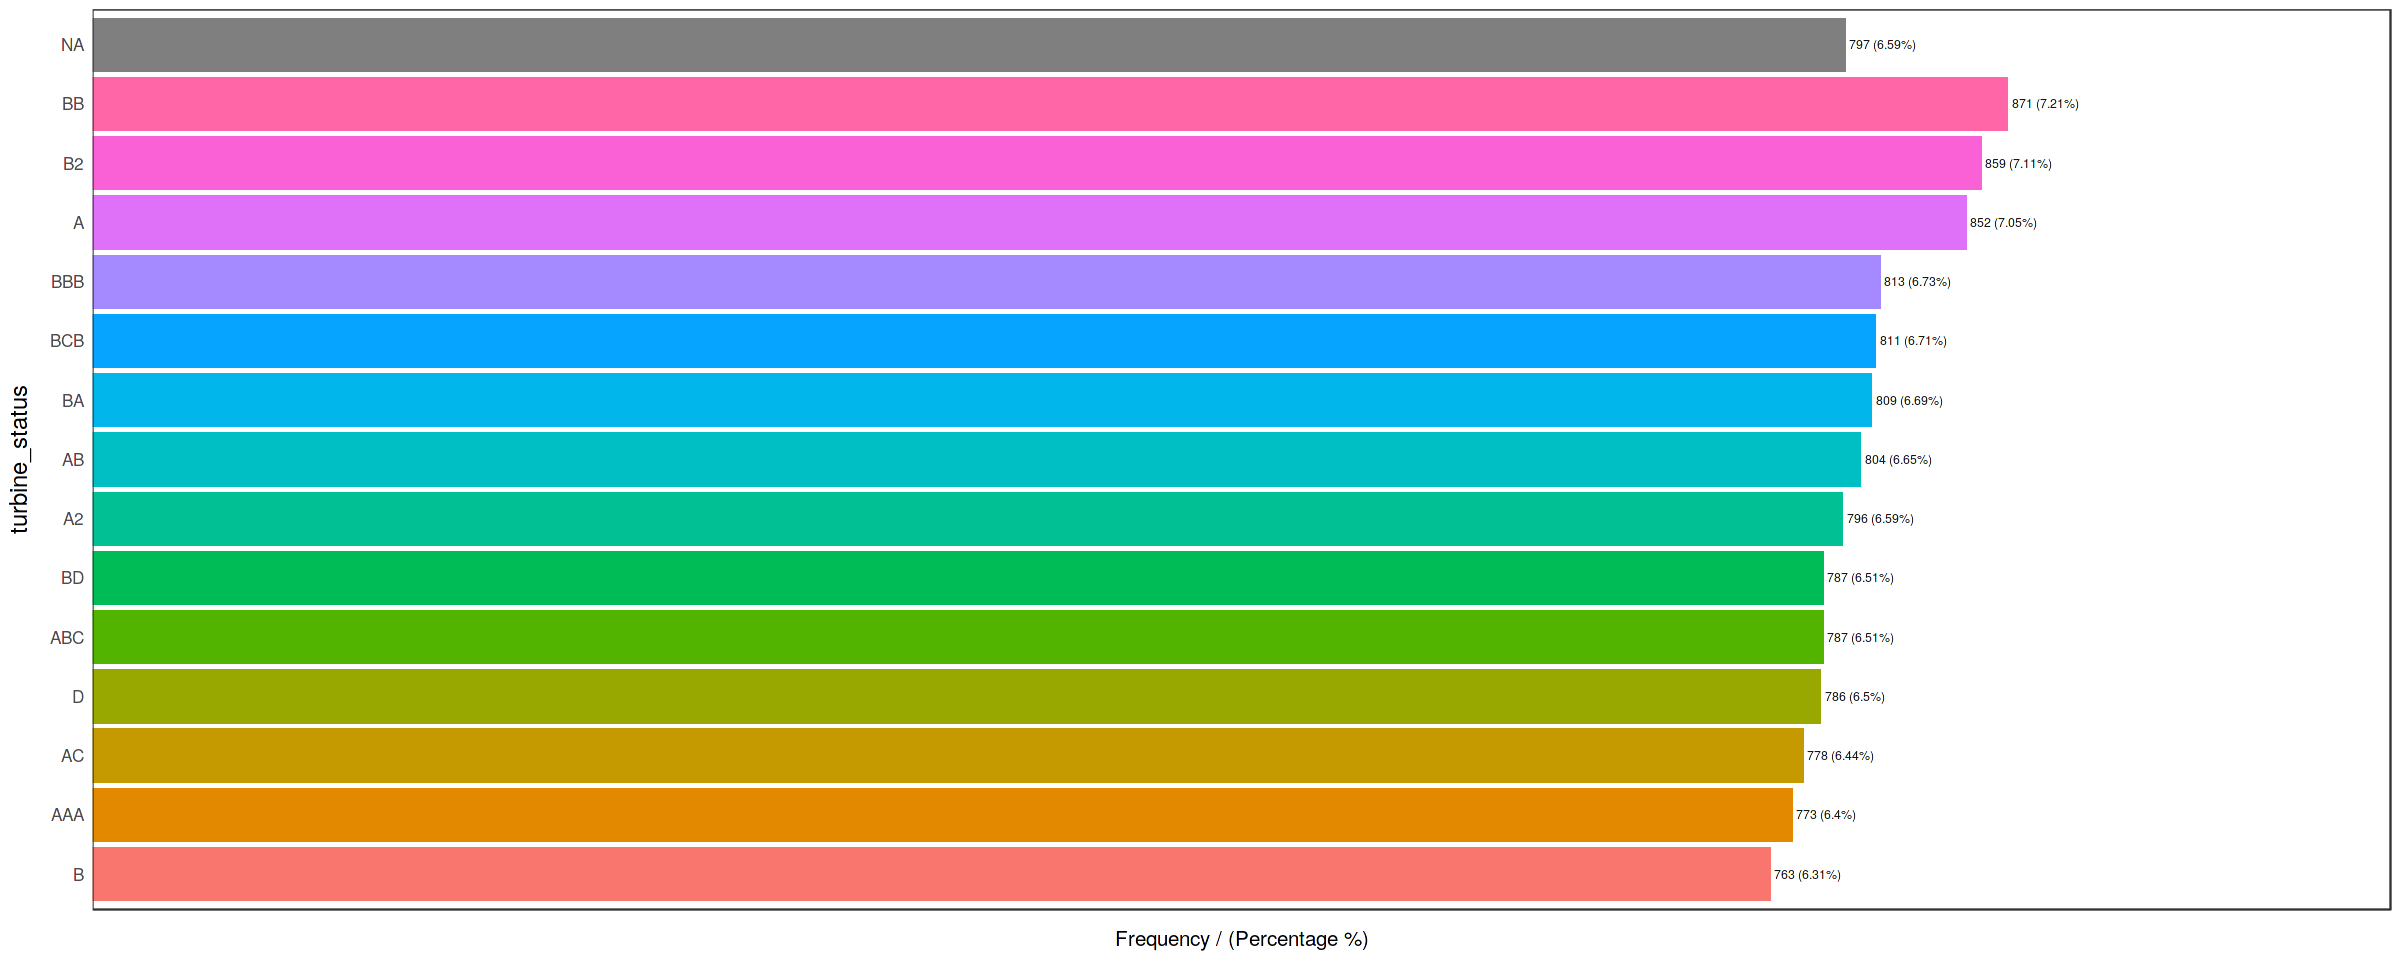

    cloud_level frequency percentage cumulative_perc
1           Low      5932      49.08           49.08
2        Medium      5893      48.76           97.84
3 Extremely Low       136       1.13           98.97
4          <NA>       125       1.03          100.00



[1] "Variables processed: turbine_status, cloud_level"

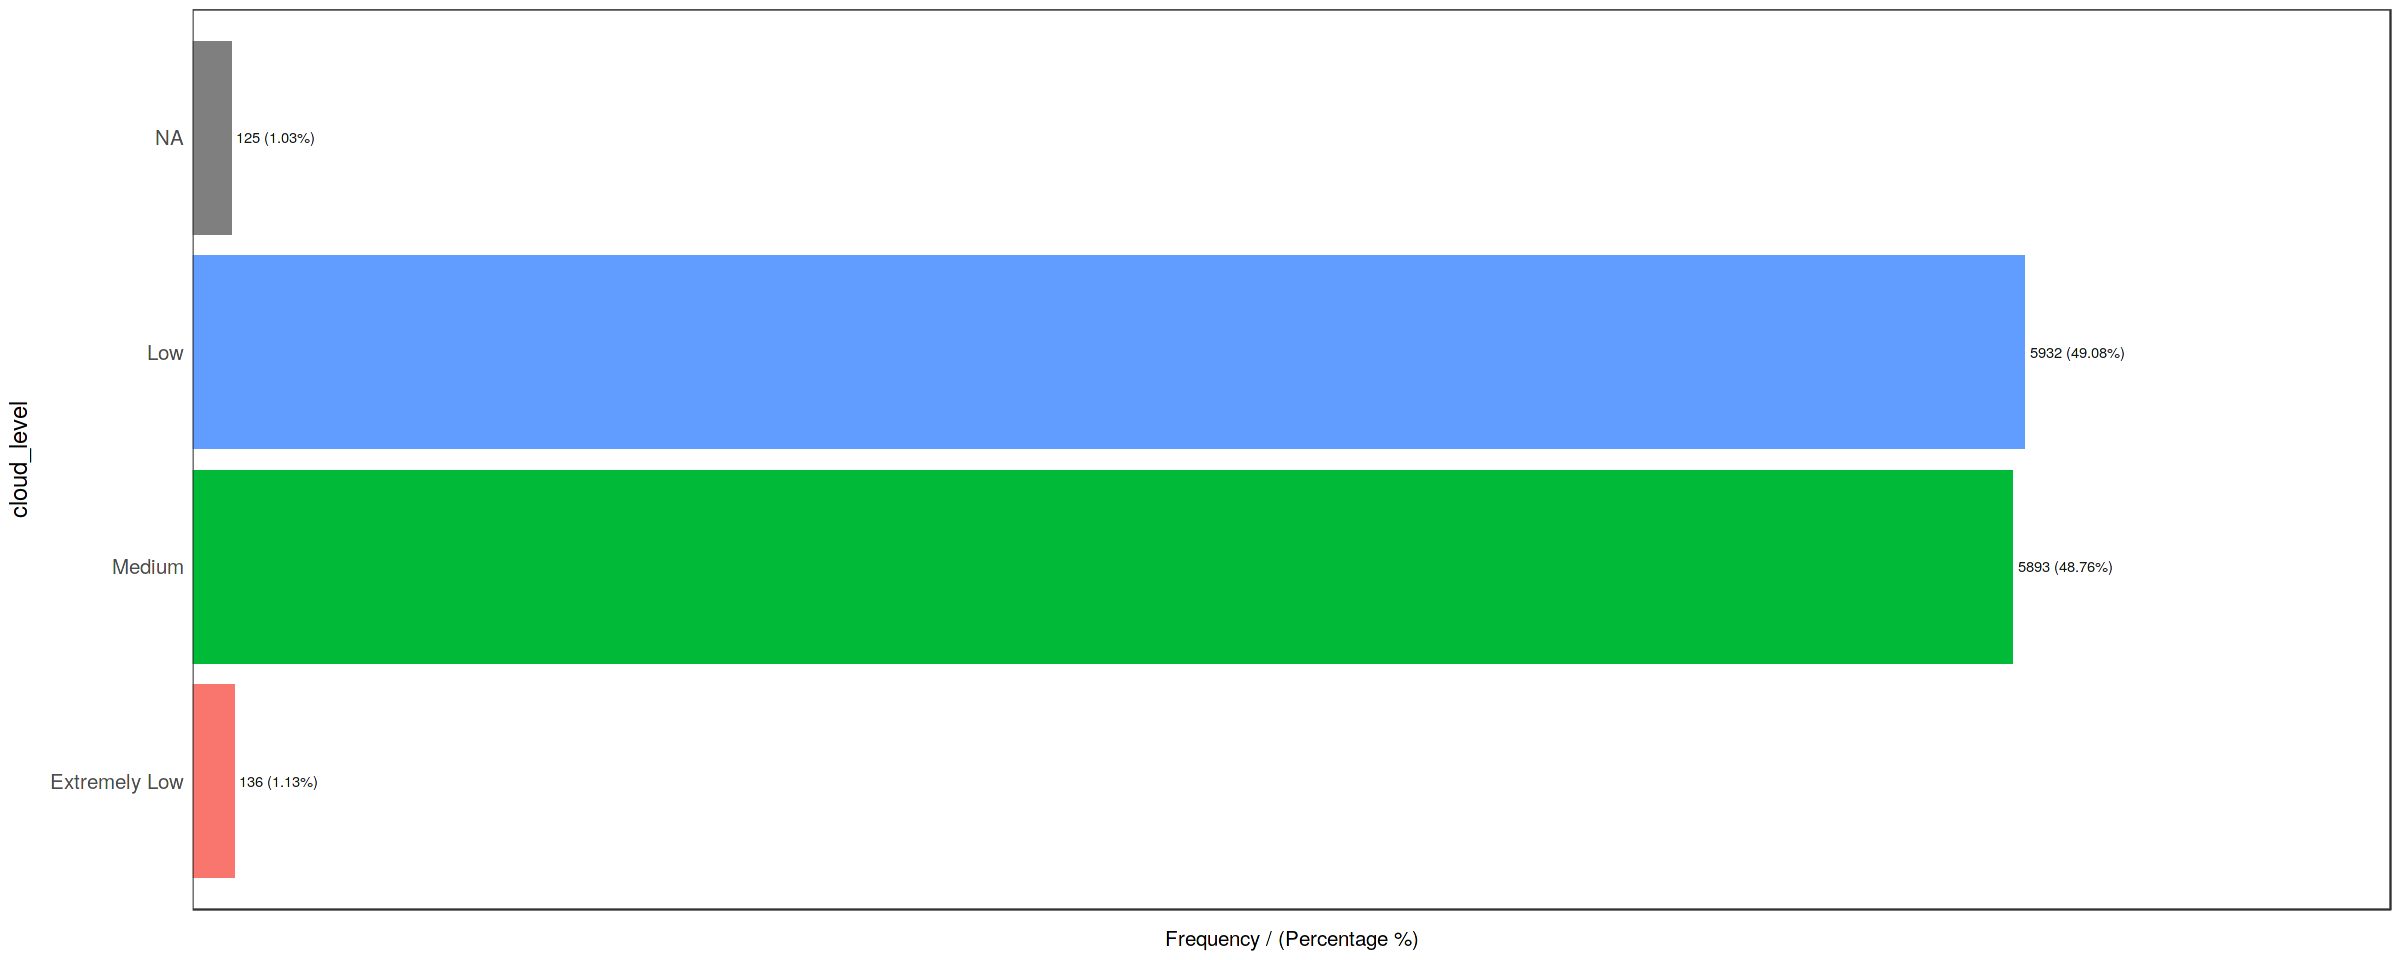

In [17]:
freq(test)

### 6. [Tableau Dashboard](https://public.tableau.com/views/WindmillPowerPrediction/WindmillAnalyticsDashboard?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

In [18]:
htmltools::tags$body(HTML("
    <div class='tableauPlaceholder' id='viz1650895231198' style='position: relative'>
    <noscript>
        <a href='#'>
            <img alt='Windmill Analytics Dashboard ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Wi&#47;WindmillPowerPrediction&#47;WindmillAnalyticsDashboard&#47;1_rss.png' style='border: none' />
        </a>
    </noscript>
    <object class='tableauViz'  style='display:none;'>
        <param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> 
        <param name='embed_code_version' value='3' /> 
        <param name='site_root' value='' />
        <param name='name' value='WindmillPowerPrediction&#47;WindmillAnalyticsDashboard' />
        <param name='tabs' value='no' />
        <param name='toolbar' value='yes' />
        <param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Wi&#47;WindmillPowerPrediction&#47;WindmillAnalyticsDashboard&#47;1.png' /> 
        <param name='animate_transition' value='yes' />
        <param name='display_static_image' value='yes' />
        <param name='display_spinner' value='yes' />
        <param name='display_overlay' value='yes' />
        <param name='display_count' value='yes' />
        <param name='language' value='en-US' />
    </object>
</div>                
<script type='text/javascript'>                    
    var divElement = document.getElementById('viz1650895231198');                    
    var vizElement = divElement.getElementsByTagName('object')[0];                    
    if (divElement.offsetWidth > 800) { 
        vizElement.style.width='100%';
        vizElement.style.height=(divElement.offsetWidth*0.75)+'px';
    } 
    else if (divElement.offsetWidth > 500) { 
        vizElement.style.width='100%';
        vizElement.style.height=(divElement.offsetWidth*0.75)+'px';
    } 
    else { 
        vizElement.style.width='100%';
        vizElement.style.height='1327px';
    }                     
    var scriptElement = document.createElement('script');                    
    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    
    vizElement.parentNode.insertBefore(scriptElement, vizElement);                
</script>
"))

Shiny tags cannot be represented in plain text (need html)

# Data Cleaning

In [19]:
# Data Imputation on Categorical & Numeric Features

imputer = function(df){
    df$cloud_level[is.na(df$cloud_level)] = "Low"
    df$turbine_status[is.na(df$turbine_status)] = "BB"
    df$cloud_level = as.numeric(factor(df$cloud_level, levels = c("Extremely Low", "Low", "Medium")))
    label = LabelEncoder$new()
    df$turbine_status = label$fit_transform(df$turbine_status)
    df = na_mean(df)
    return(df)
}

train = imputer(train)
test = imputer(test)

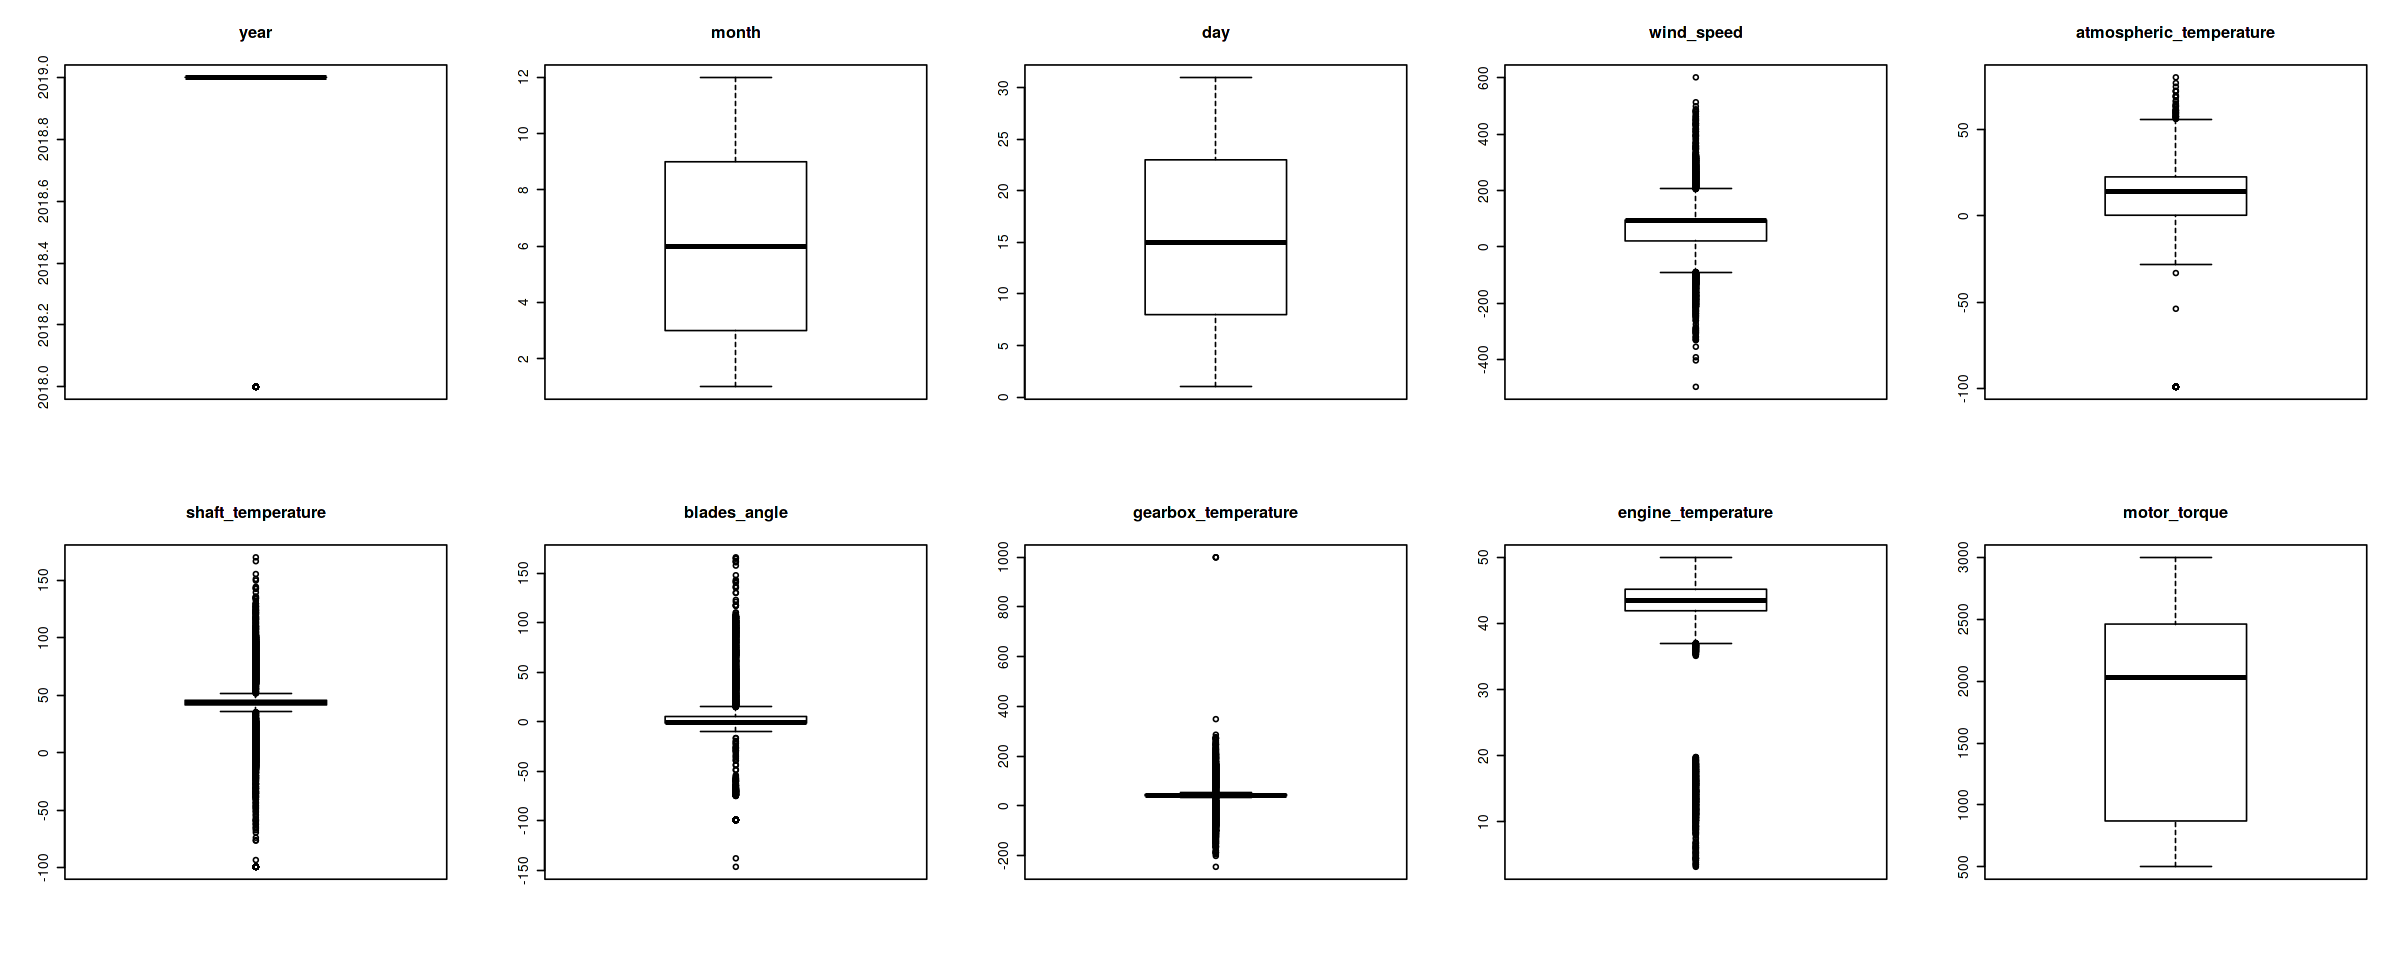

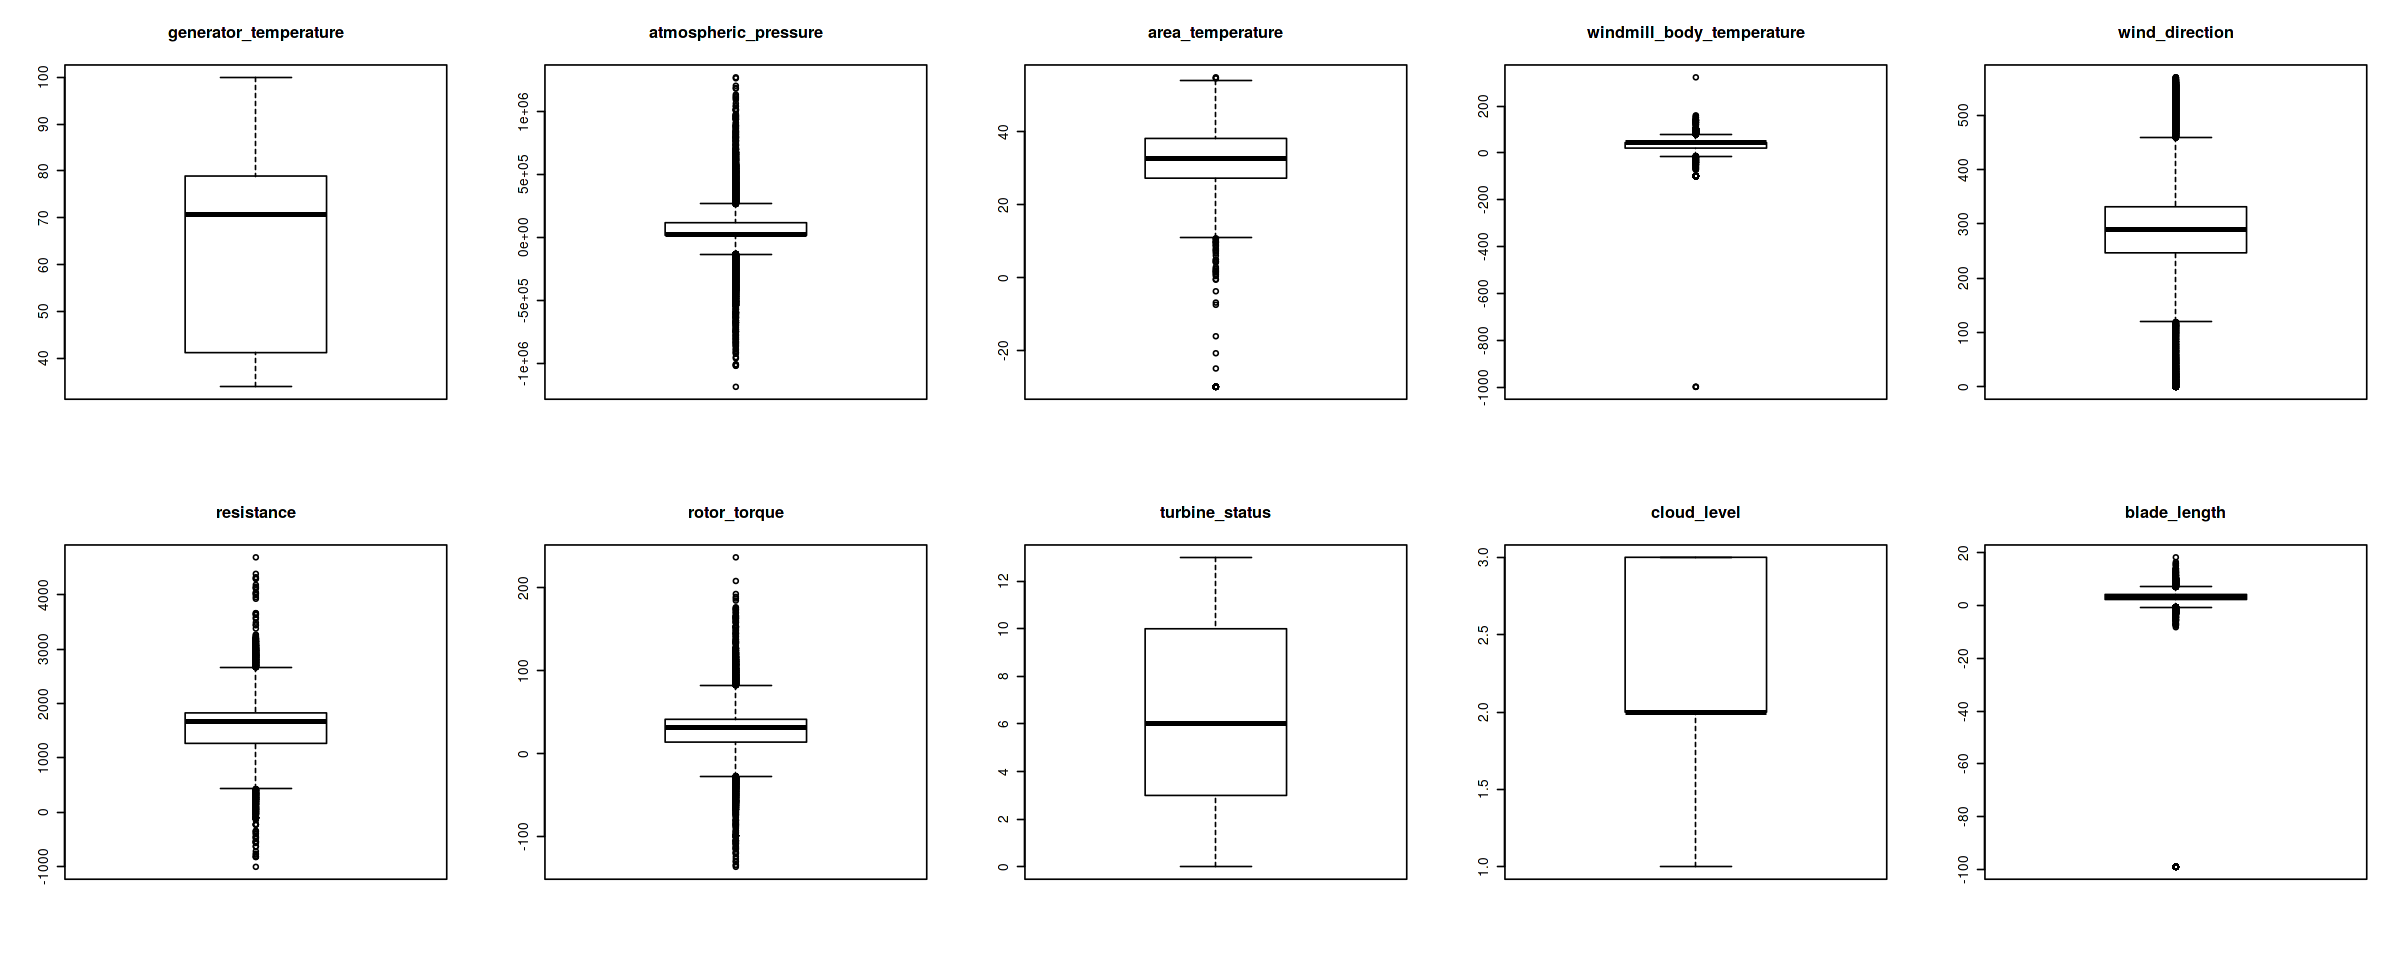

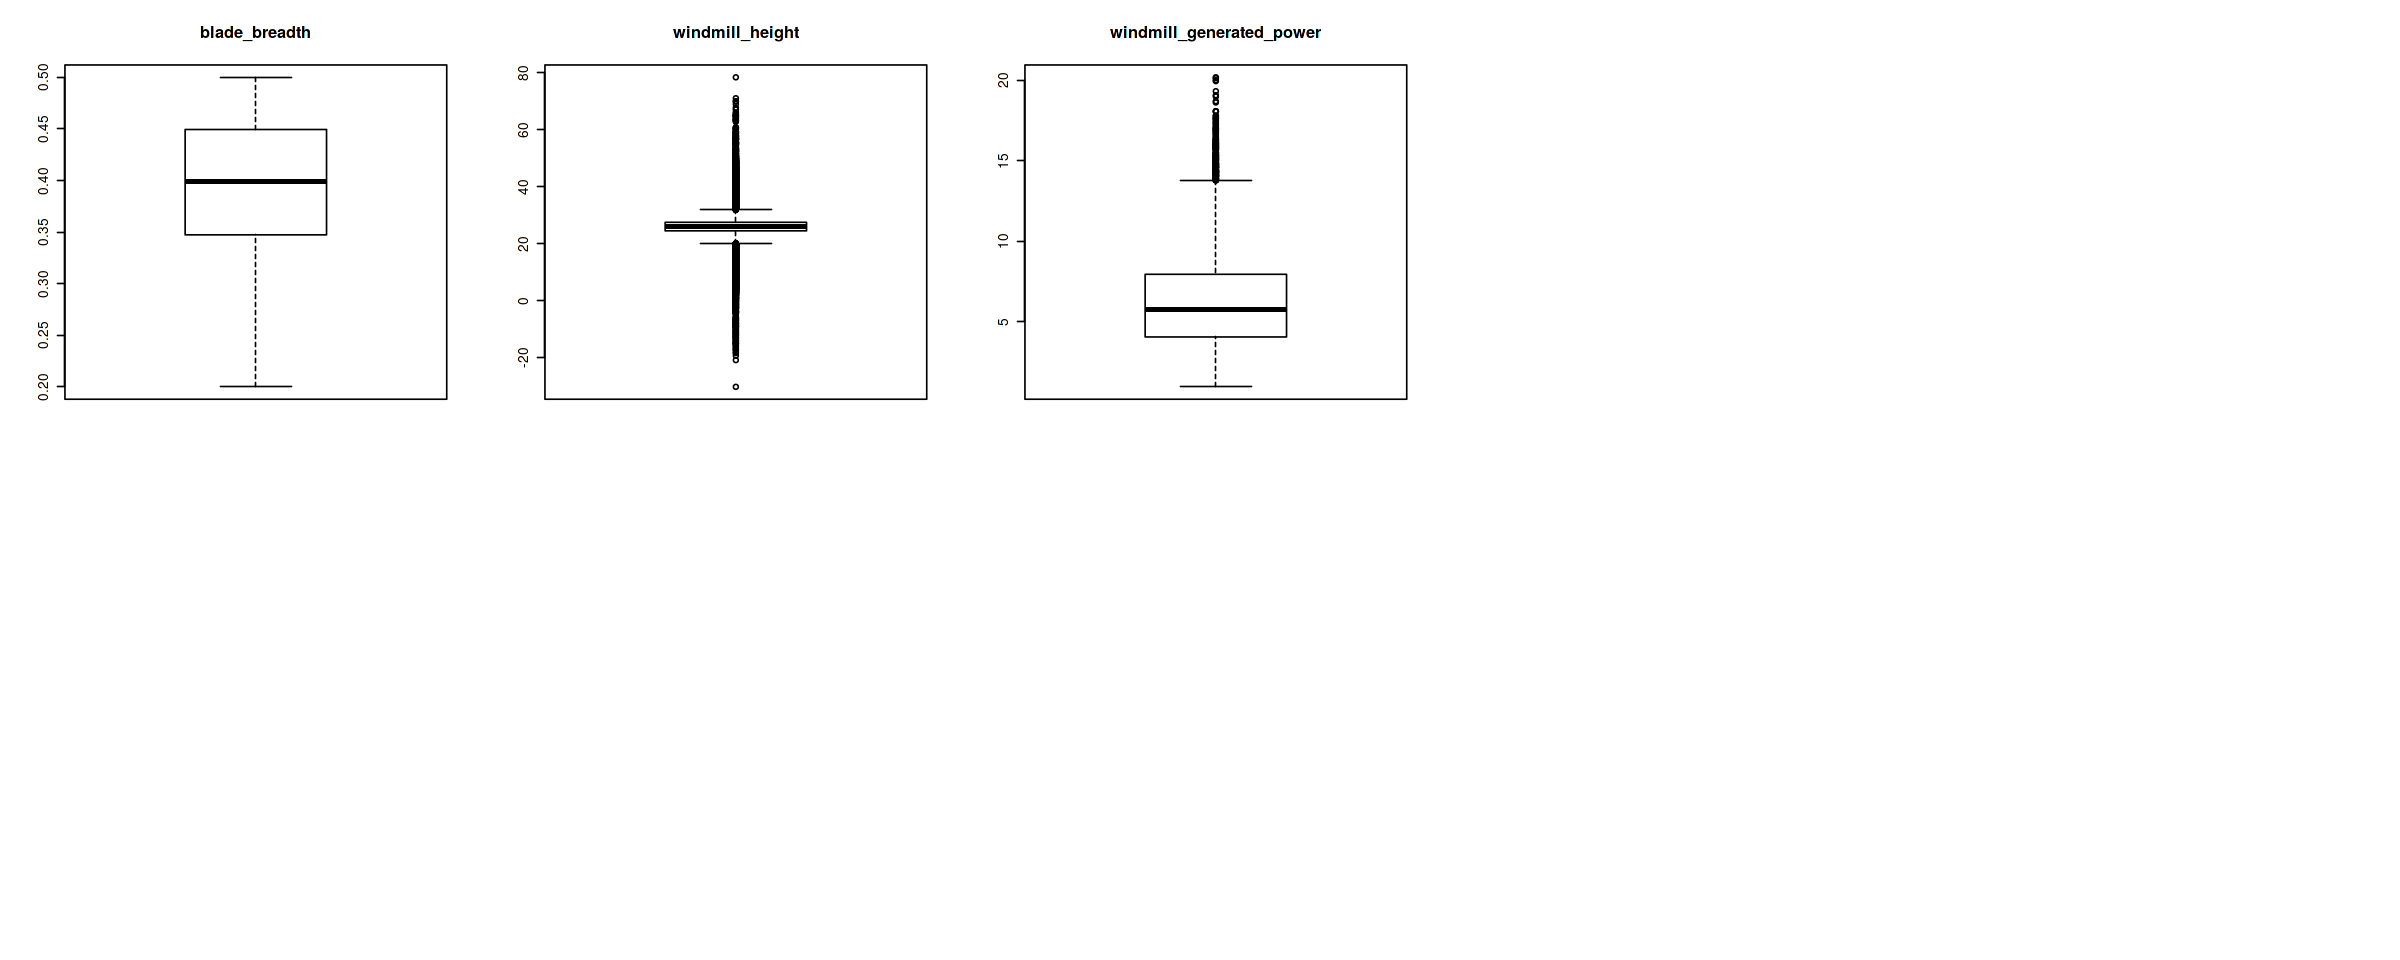

In [20]:
# Box Plot Before Removing Outliers

par(mfrow = c(2,5))
for (i in 1:length(train)) 
    boxplot(train[,i], main=names(train[i]), type="l")

In [21]:
# Removing Outliers

train = rm.outlier(train, fill = TRUE, median = TRUE)
test = rm.outlier(test, fill = TRUE, median = TRUE)

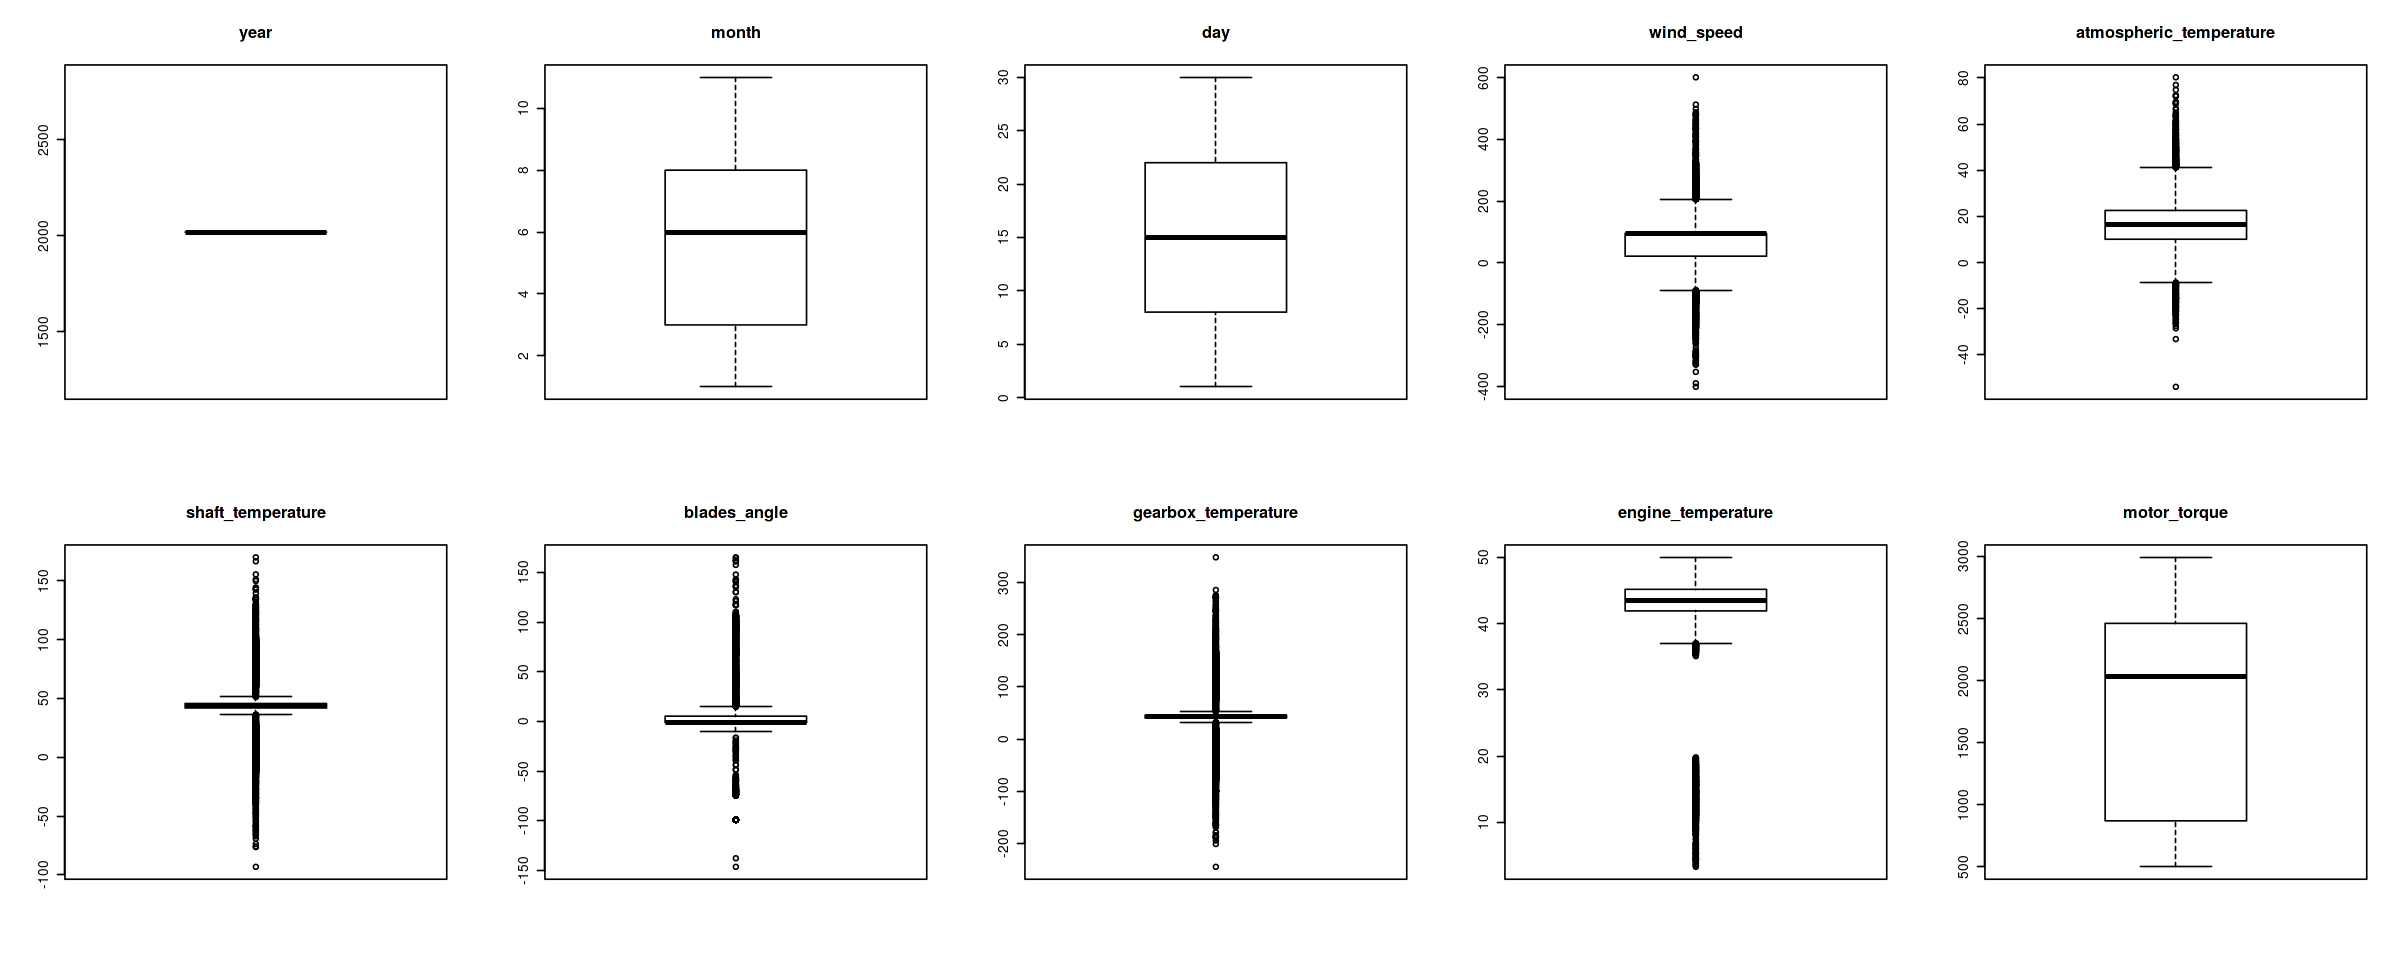

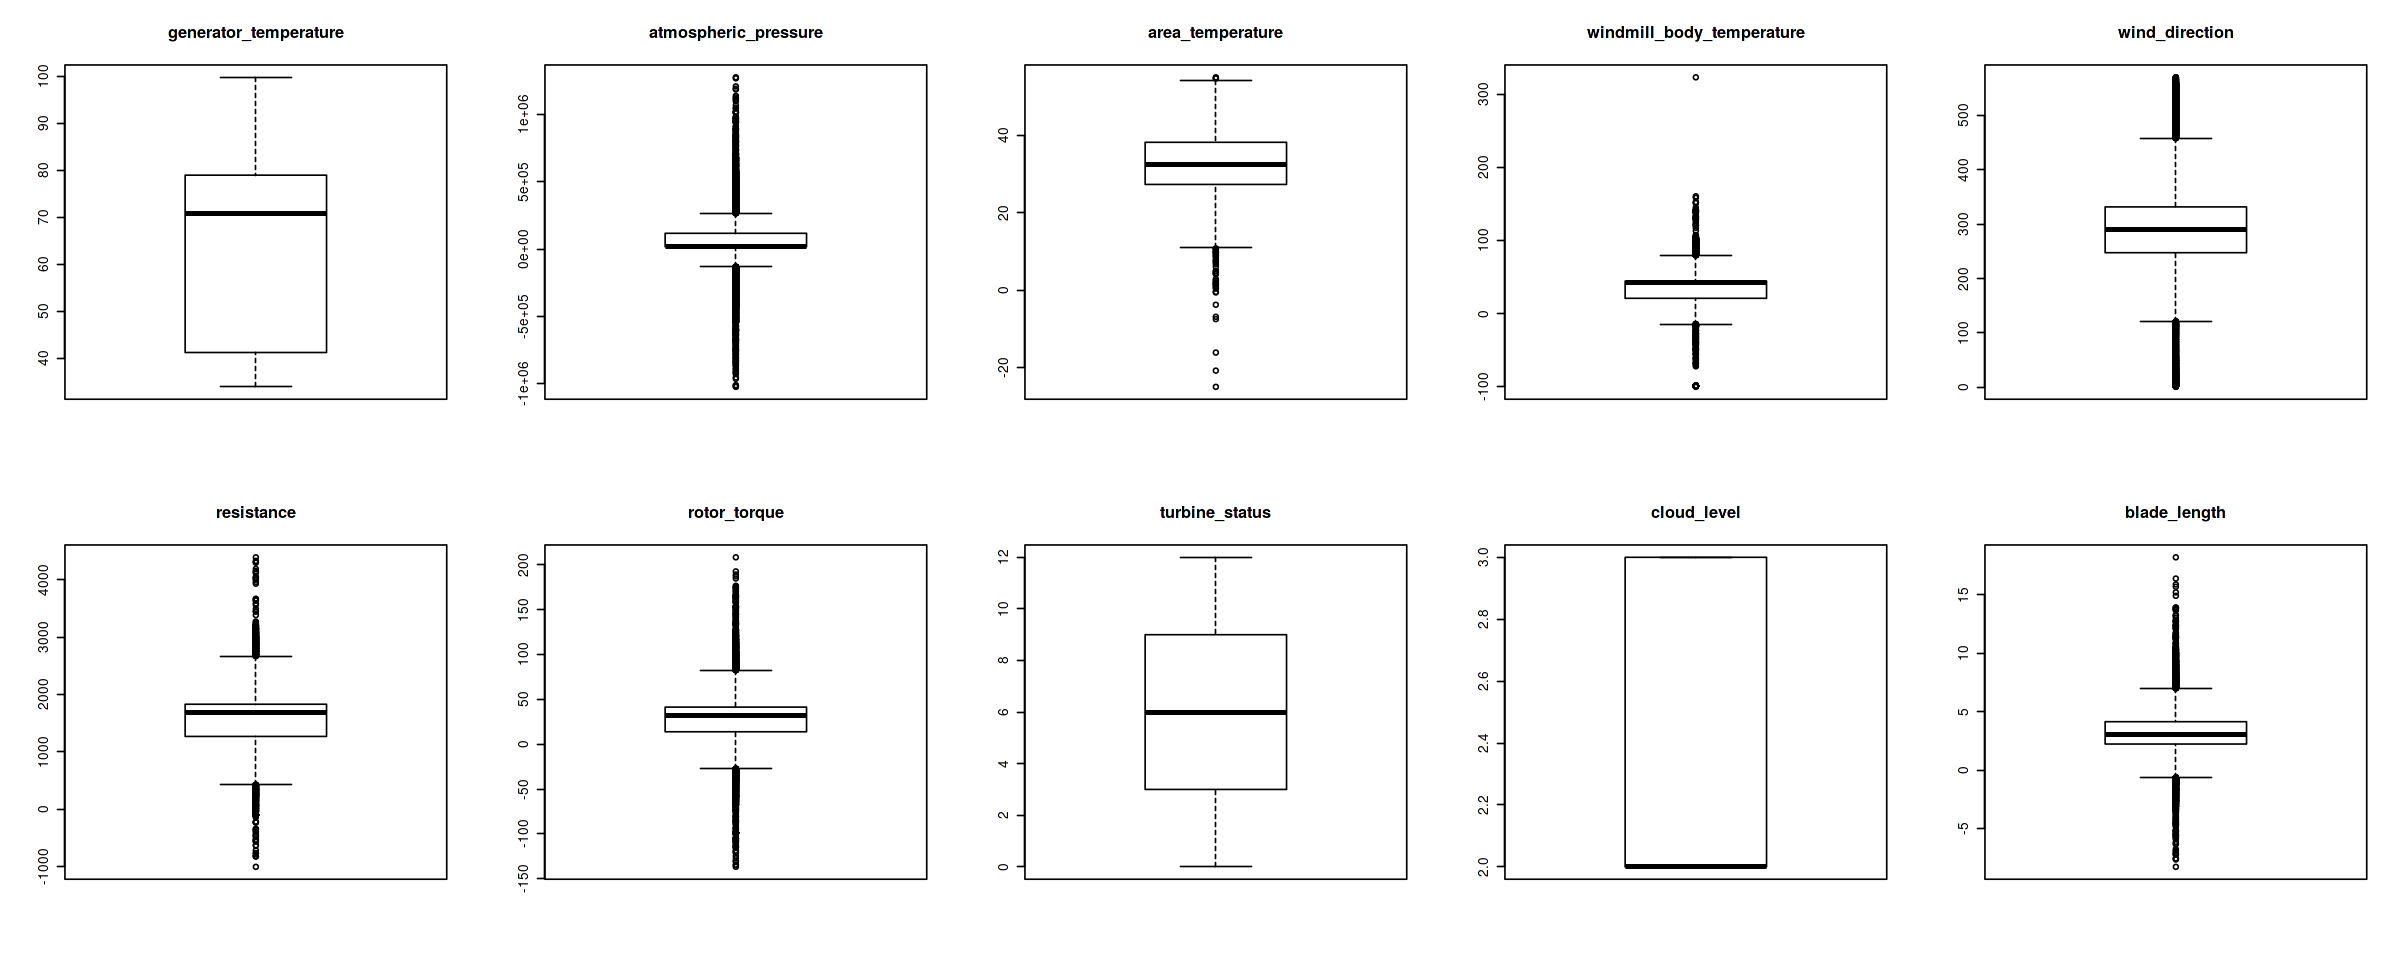

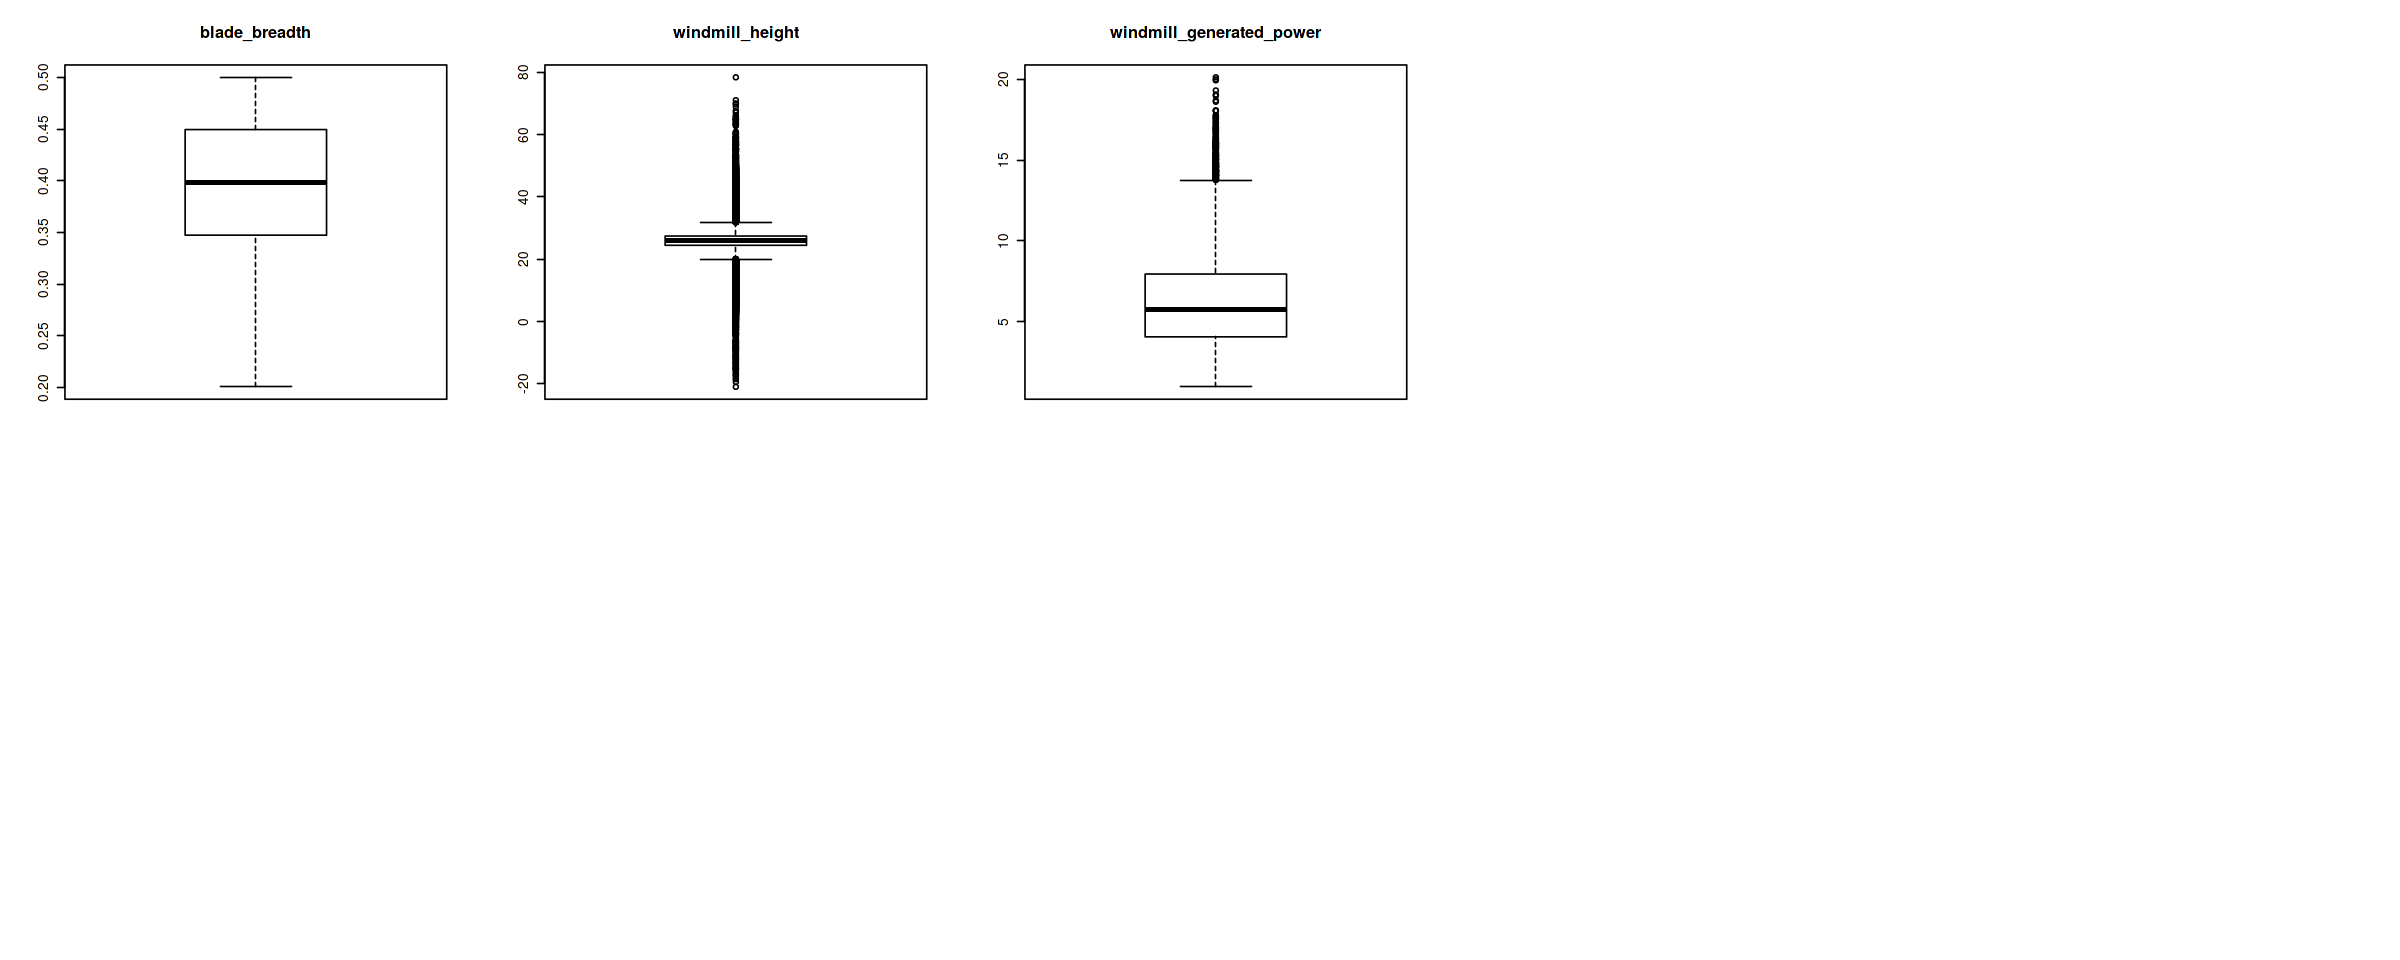

In [22]:
# Box Plot After Removing Outliers

par(mfrow = c(2,5))
for (i in 1:length(train)) 
    boxplot(train[,i], main = names(train[i]), type="l")

In [23]:
glimpse(train)

Rows: 27,993
Columns: 23
$ year                      <dbl> 2019, 2019, 2019, 2019, 2019, 2019, 2019, 20…
$ month                     <dbl> 8, 11, 9, 6, 5, 3, 4, 7, 6, 6, 5, 11, 7, 7, …
$ day                       <dbl> 4, 5, 14, 25, 4, 22, 17, 8, 7, 28, 24, 22, 5…
$ wind_speed                <dbl> 94.82002, 241.83273, 95.48472, 238.81942, 10…
$ atmospheric_temperature   <dbl> 16.3619258, 27.7647848, 0.3711841, 16.361925…
$ shaft_temperature         <dbl> 41.723019, 43.752624, 41.855473, 45.443914, …
$ blades_angle              <dbl> -0.90342290, -99.00000000, 12.65276348, 15.1…
$ gearbox_temperature       <dbl> 82.41057, 44.10492, 42.32210, 44.75964, -17.…
$ engine_temperature        <dbl> 42.52302, 46.25887, 42.87855, 47.28210, 43.4…
$ motor_torque              <dbl> 2563.1245, 2372.3841, 1657.1696, 2888.1341, …
$ generator_temperature     <dbl> 76.66556, 78.12980, 67.65447, 95.38997, 37.4…
$ atmospheric_pressure      <dbl> 103402.96, 17030.90, 16125.93, 18689.73, 114…
$ area_temperat

In [24]:
glimpse(test)

Rows: 12,086
Columns: 22
$ year                      <dbl> 2019, 2019, 2019, 2019, 2019, 2019, 2019, 20…
$ month                     <dbl> 4, 3, 8, 6, 8, 10, 6, 6, 1, 8, 5, 9, 7, 7, 2…
$ day                       <dbl> 17, 30, 10, 26, 27, 29, 16, 27, 14, 2, 24, 1…
$ wind_speed                <dbl> 94.32427, 10.08887, 347.15209, 24.47200, 96.…
$ atmospheric_temperature   <dbl> 17.6411856, 13.9781194, 31.4230347, 16.45901…
$ shaft_temperature         <dbl> 89.714193, 43.272846, 41.076640, 14.375078, …
$ blades_angle              <dbl> 51.1467876, 46.5163939, 26.9316016, 66.51395…
$ gearbox_temperature       <dbl> 40.46056, 40.02779, 43.10912, 13.74125, 121.…
$ engine_temperature        <dbl> 39.59473, 41.17686, 43.43956, 15.57747, 43.9…
$ motor_torque              <dbl> 1073.2027, 517.4364, 1480.7165, 887.9795, 20…
$ generator_temperature     <dbl> 66.83004, 37.28416, 70.01076, 41.44526, 68.0…
$ atmospheric_pressure      <dbl> 16681.04, 54283.32, 214812.84, 54283.32, 168…
$ area_temperat

# Feature Selection

### 1. Correlation Matrix

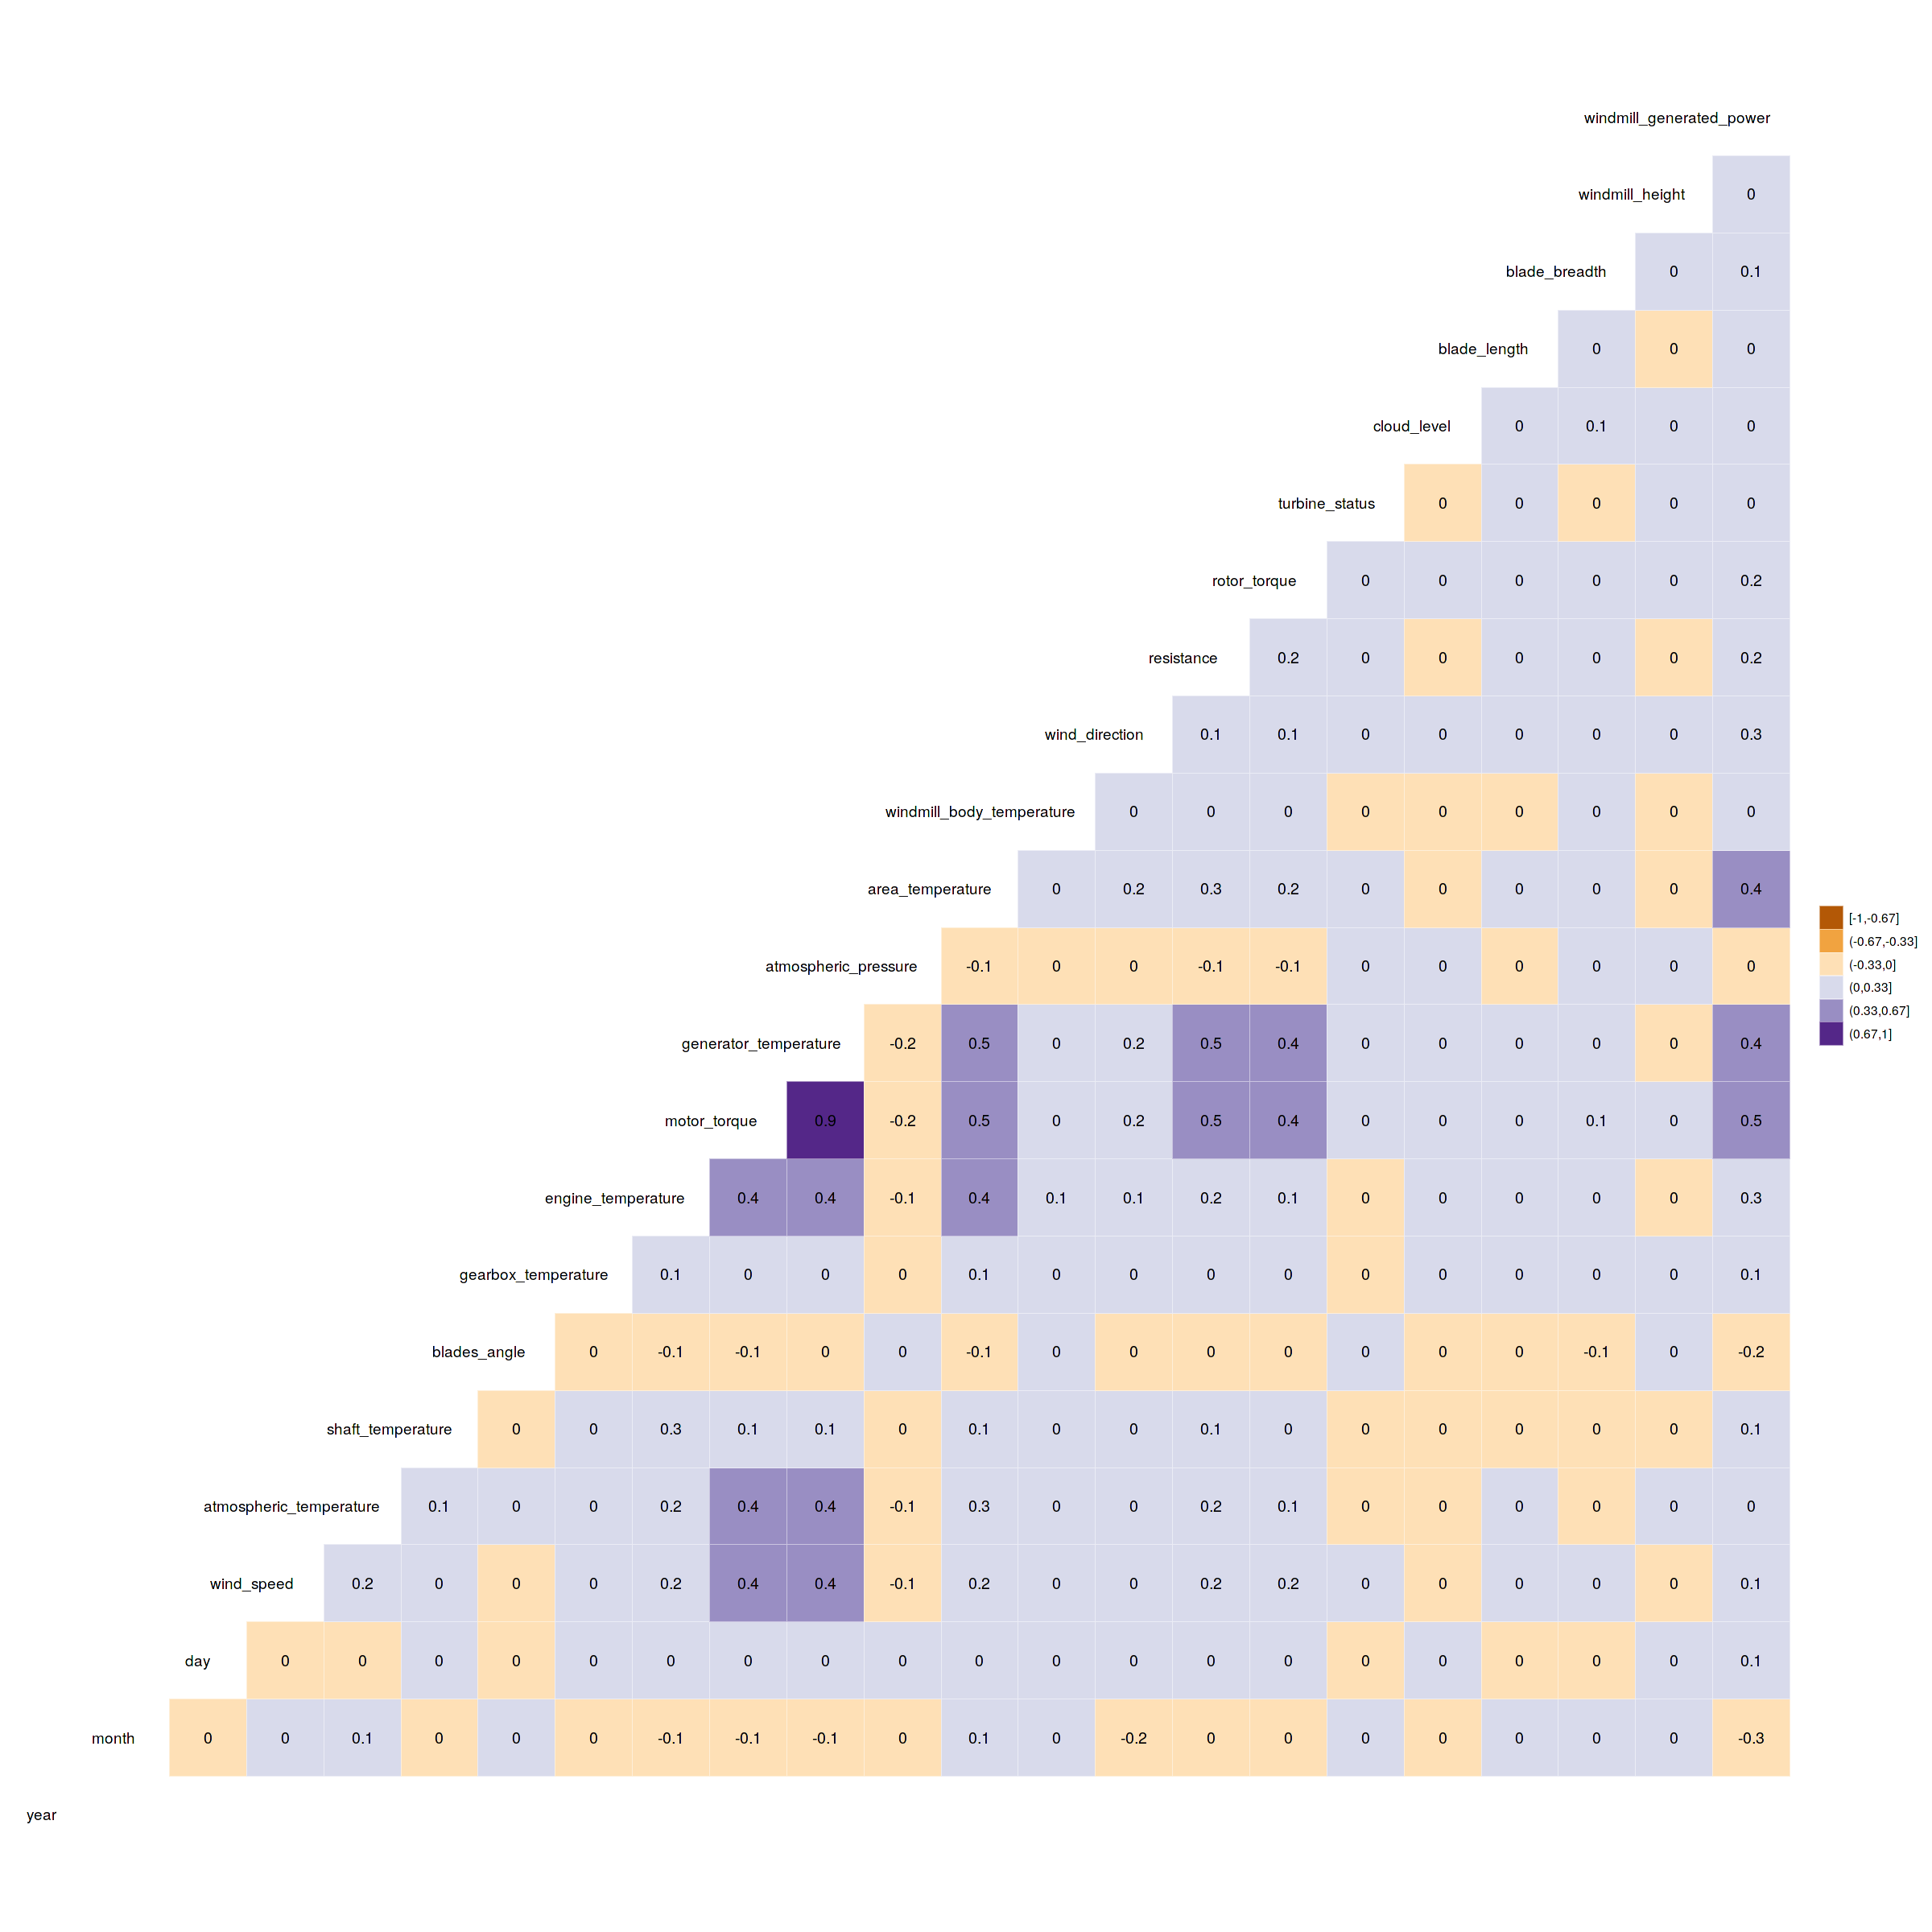

In [25]:
options(repr.plot.width = 20, repr.plot.height = 20)

ggcorr(train, nbreaks = 6, label = TRUE, label_color = "black", palette = "PuOr", hjust = 0.9)

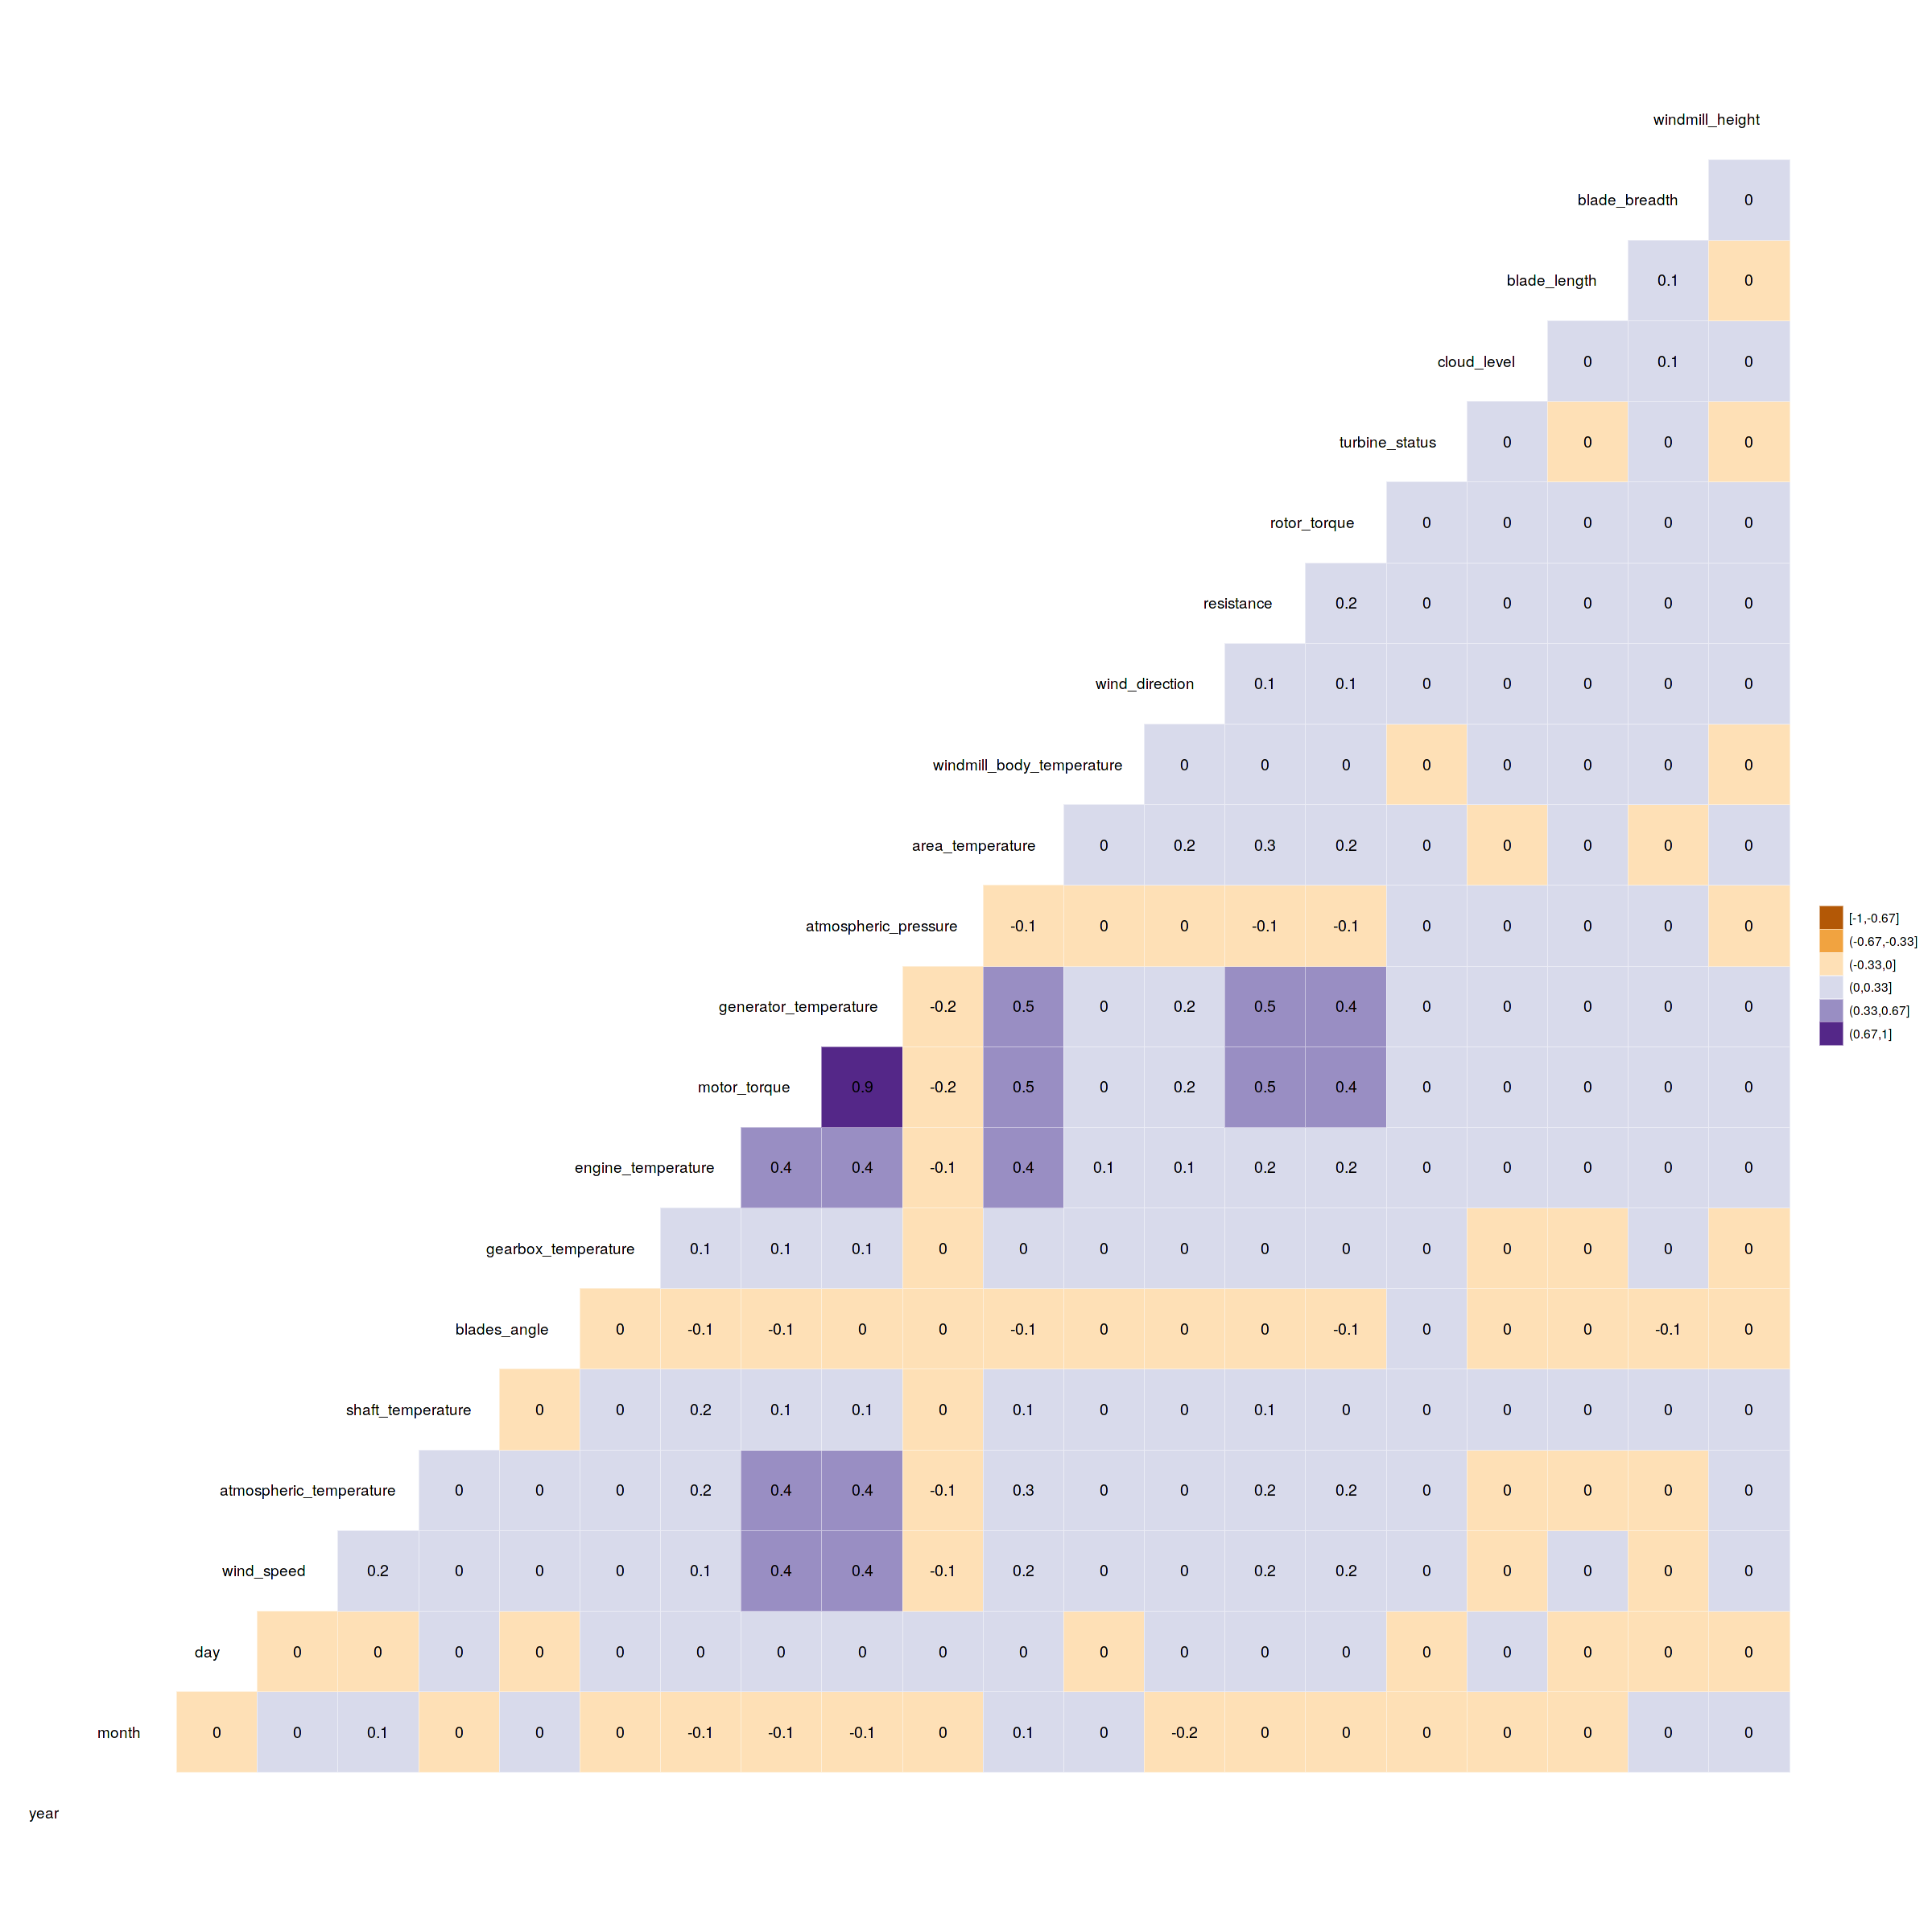

In [26]:
ggcorr(test, nbreaks = 6, label = TRUE, label_color = "black", palette = "PuOr", hjust = 0.9)

### 2. Forward + Backward Selection

In [27]:
full.model = lm(windmill_generated_power ~., data = train)
step.model = stepAIC(full.model, direction = "both", trace = FALSE)
summary(step.model)


Call:
lm(formula = windmill_generated_power ~ month + day + wind_speed + 
    atmospheric_temperature + shaft_temperature + blades_angle + 
    gearbox_temperature + engine_temperature + motor_torque + 
    generator_temperature + atmospheric_pressure + area_temperature + 
    windmill_body_temperature + wind_direction + resistance + 
    turbine_status + cloud_level + blade_length + blade_breadth, 
    data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.4228 -1.2745 -0.1393  1.1177 16.1918 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                1.301e+00  1.413e-01   9.211  < 2e-16 ***
month                     -2.116e-01  4.190e-03 -50.498  < 2e-16 ***
day                        2.715e-02  1.356e-03  20.018  < 2e-16 ***
wind_speed                -2.294e-03  1.676e-04 -13.687  < 2e-16 ***
atmospheric_temperature   -2.956e-02  1.216e-03 -24.314  < 2e-16 ***
shaft_temperature         -1.048e-03  6.413e-04  -1.634

### 3. Feature Elimination 

In [28]:
# We Select features suggested by FBE & Correlation Matrix i.e. excluding Generator Temperator + FBE eliminated features.

train = dplyr::select(train, month, day, wind_speed, atmospheric_temperature, shaft_temperature, blades_angle, 
               gearbox_temperature, engine_temperature, motor_torque, atmospheric_pressure,
               area_temperature, windmill_body_temperature, wind_direction, resistance, turbine_status, cloud_level, 
               blade_length, blade_breadth, windmill_generated_power)

test = dplyr::select(test, month, day, wind_speed, atmospheric_temperature, shaft_temperature, blades_angle, 
               gearbox_temperature, engine_temperature, motor_torque, atmospheric_pressure,
               area_temperature, windmill_body_temperature, wind_direction, resistance, turbine_status, cloud_level, 
               blade_length, blade_breadth)

# Data Modeling: AutoML

In [29]:
h2o.init()

train.h2o = as.h2o(train)
test.h2o = as.h2o(test)

y.dep = ncol(train)        # Dependent Variable 
x.indep = c(1:ncol(test))  # Independent Variables 


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpZTMBBe/filed28d5aad8/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpZTMBBe/filed426508be/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 536 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    2 years and 21 days !!! 
    H2O cluster name:           H2O_started_from_R_root_rst097 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   4.40 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensi

In [30]:
# Selecting 25 models for Auto-ML

aml = h2o.automl(x = x.indep, y = y.dep, training_frame = train.h2o, 
                 max_models = 25, max_runtime_secs = 600, seed = 42)

  |======================================================================| 100%


In [31]:
# AutoML Leaderboard

lb = aml@leaderboard
print(lb, n = nrow(lb)) 

                                              model_id mean_residual_deviance
1     StackedEnsemble_AllModels_AutoML_20220425_141147              0.2552745
2  StackedEnsemble_BestOfFamily_AutoML_20220425_141147              0.2560969
3                         GBM_4_AutoML_20220425_141147              0.2703517
4                         GBM_3_AutoML_20220425_141147              0.2712797
5           GBM_grid__1_AutoML_20220425_141147_model_4              0.2724086
6                         GBM_2_AutoML_20220425_141147              0.2766677
7           GBM_grid__1_AutoML_20220425_141147_model_1              0.2829048
8       XGBoost_grid__1_AutoML_20220425_141147_model_4              0.2846452
9                         GBM_1_AutoML_20220425_141147              0.2939329
10          GBM_grid__1_AutoML_20220425_141147_model_2              0.3075728
11      XGBoost_grid__1_AutoML_20220425_141147_model_1              0.3101143
12                    XGBoost_1_AutoML_20220425_141147          

In [32]:
q = h2o.getModel(lb[3, 1])
h2o.varimp(q)

variable,relative_importance,scaled_importance,percentage
<chr>,<dbl>,<dbl>,<dbl>
motor_torque,397597.8438,1.0000000000,0.4273172822
blades_angle,185485.0156,0.4665141387,0.1993495538
resistance,152902.2188,0.3845650100,0.1643312749
engine_temperature,74410.7969,0.1871509065,0.0799728167
atmospheric_pressure,36393.5859,0.0915336602,0.0391139149
gearbox_temperature,21099.6914,0.0530679221,0.0226768403
month,20385.7832,0.0512723686,0.0219095692
day,10339.9756,0.0260061158,0.0111128627
area_temperature,10164.7969,0.0255655231,0.0109245899


#### Predicting Using The LeaderBoard's Top Model

In [33]:
yp = h2o.predict(aml@leader, test.h2o)
Ans = as.data.frame(yp)

  |======================================================================| 100%


# Saving Model & Submission Data 

In [34]:
p = read_csv("../input/predict-the-powerkwh-produced-by-windmills/dataset/test.csv")
p = dplyr::select(p, tracking_id, datetime)
Ans = cbind(p, Ans)
names(Ans)[names(Ans) == "predict"] = "windmill_generated_power(kW/h)"

write.csv(Ans, "aml_ans.csv", row.names = FALSE)
saveRDS(aml, "aml_model.rds")


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  tracking_id = col_character(),
  datetime = col_datetime(format = ""),
  turbine_status = col_character(),
  cloud_level = col_character()
)
ℹ Use `spec()` for the full column specifications.




# Do upvote if you find this Notebook useful... 😃